# Ejercicio 1 - Expermentación Práctica

## Task 1 - Preparación del conjunto de datos

In [23]:
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Cargar el conjunto de datos Iris
iris = load_iris()
X, y = iris.data, iris.target

# Convertir a tensores de PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


## Task 2 - Arquitectura modelo

In [24]:
class FeedforwardNNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.0):
        super(FeedforwardNNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Parámetros del modelo
input_size = 4
hidden_size = 10
output_size = 3


## Task 3 - Funciones de Pérdida

In [25]:
# Funciones de Pérdida
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'MSELoss': nn.MSELoss(),  # Requiere conversión a one-hot
    'NLLLoss': nn.NLLLoss()
}

# Función para convertir etiquetas a formato one-hot
def to_one_hot(y, num_classes):
    return torch.eye(num_classes)[y]


## Task 4 - Técnicas de Regularización

In [26]:
# Regularizaciones
regularizations = {
    'None': (0.0, 0.0, 0.0),
    'L1': (0.001, 0.0, 0.0),
    'L2': (0.0, 0.001, 0.0),
    'Dropout': (0.0, 0.0, 0.5)
}

# Función para aplicar regularización
def apply_l1_l2_regularization(model, l1_lambda, l2_lambda):
    l1_norm = sum(param.abs().sum() for param in model.parameters())
    l2_norm = sum(param.pow(2.0).sum() for param in model.parameters())
    return l1_lambda * l1_norm + l2_lambda * l2_norm



## Task 5 - Algoritmos de Optimización

In [27]:
# Algoritmos de Optimización
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'RMSprop': torch.optim.RMSprop
}


## Task 6 - Experimentación y Análisis

        Loss Function Regularization Optimizer  Final Accuracy  Time (s)
0    CrossEntropyLoss           None       SGD        0.866667  0.535511
1    CrossEntropyLoss           None      Adam        0.966667  0.768402
2    CrossEntropyLoss           None   RMSprop        0.966667  0.721725
3    CrossEntropyLoss             L1       SGD        0.900000  0.643309
4    CrossEntropyLoss             L1      Adam        0.966667  0.707974
..                ...            ...       ...             ...       ...
151           NLLLoss             L2      Adam        0.300000  1.142322
152           NLLLoss             L2   RMSprop        0.366667  1.042947
153           NLLLoss        Dropout       SGD        0.366667  0.928355
154           NLLLoss        Dropout      Adam        0.300000  1.198200
155           NLLLoss        Dropout   RMSprop        0.300000  1.158916

[156 rows x 5 columns]


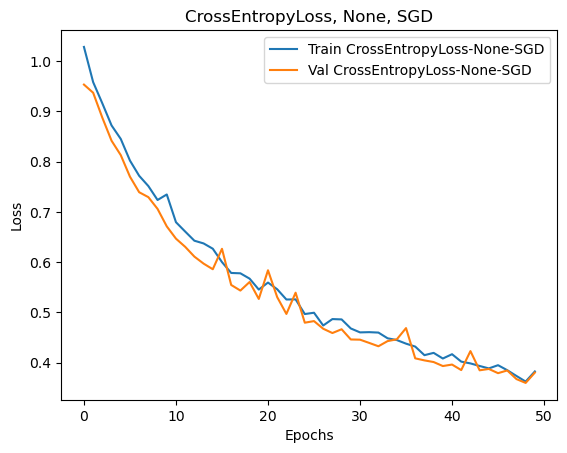

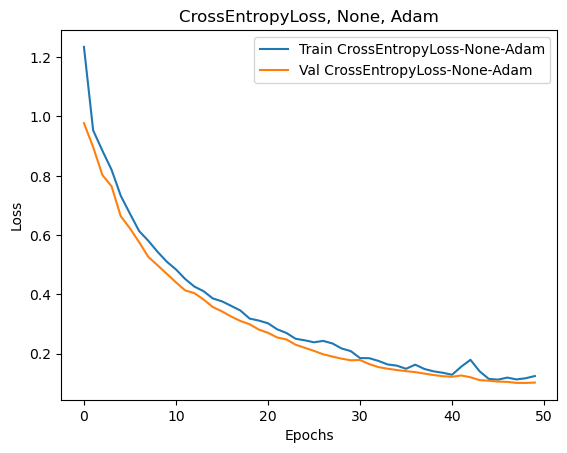

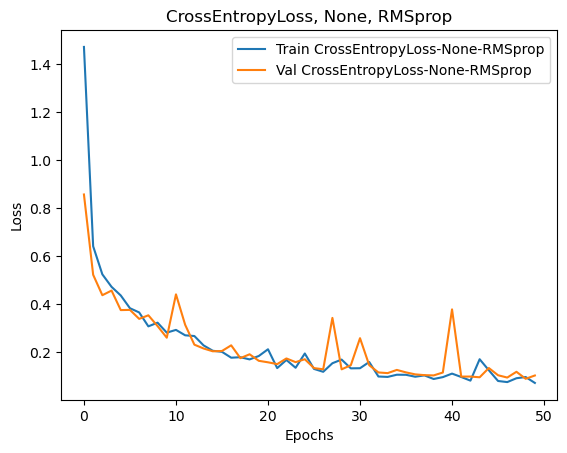

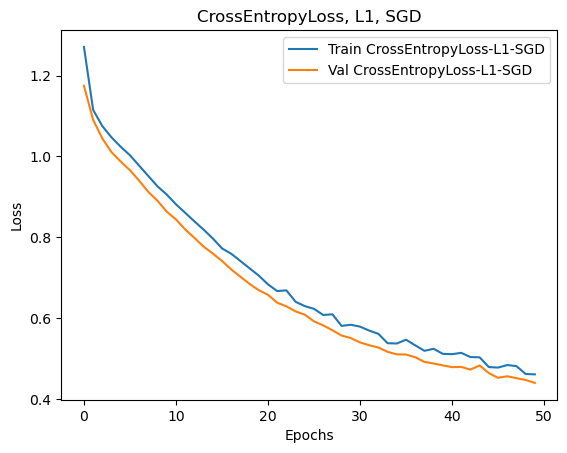

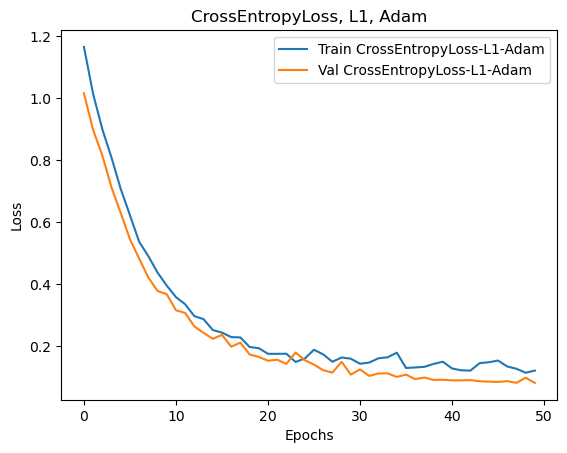

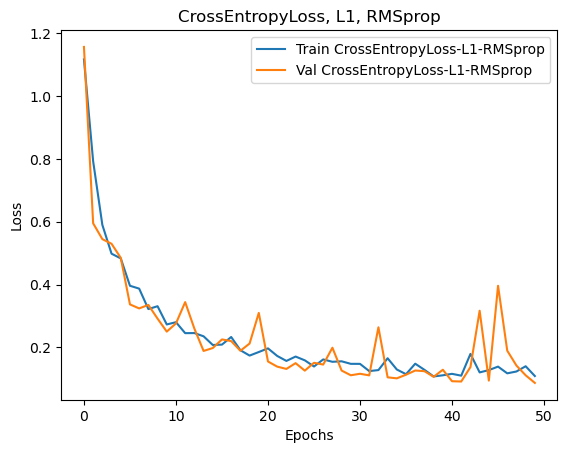

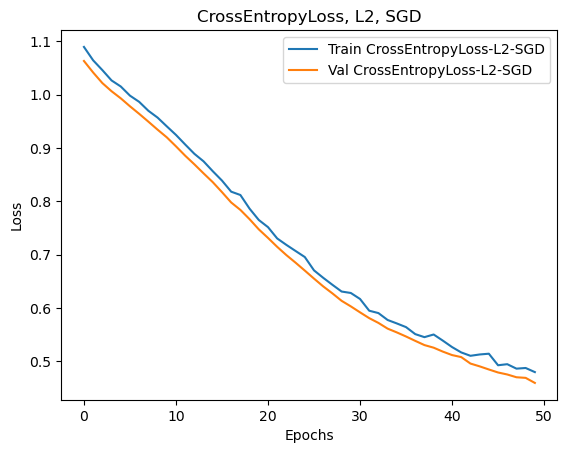

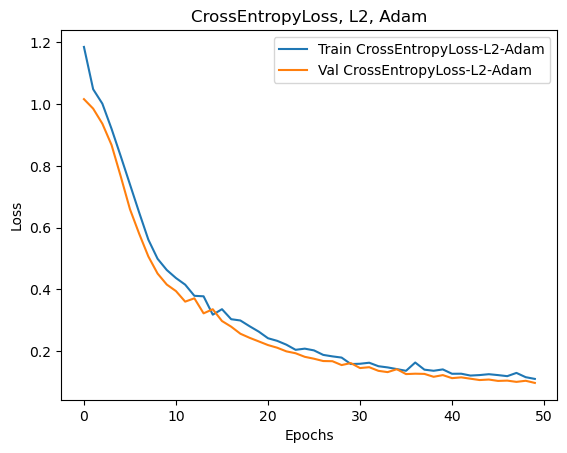

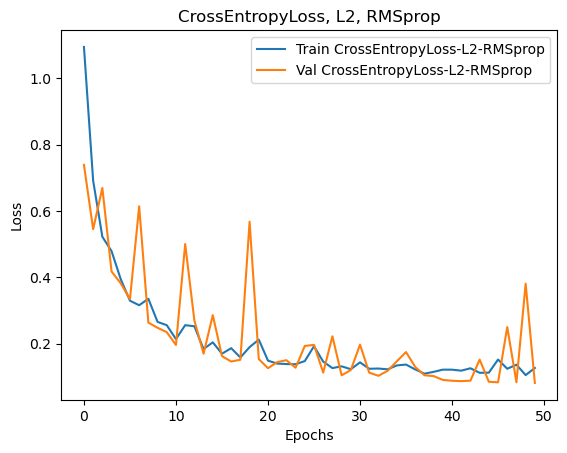

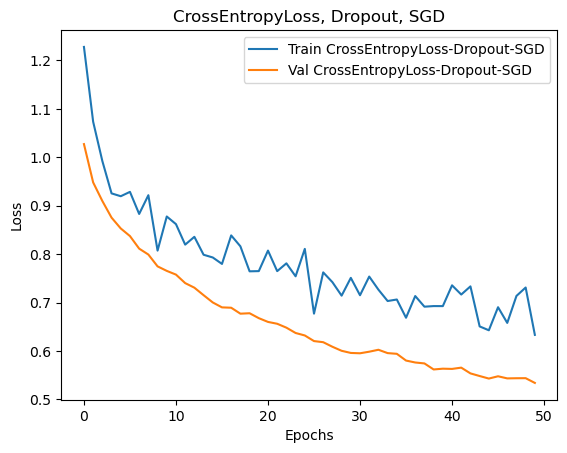

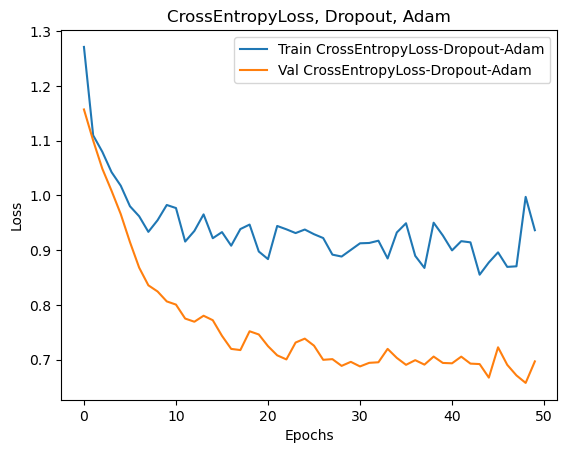

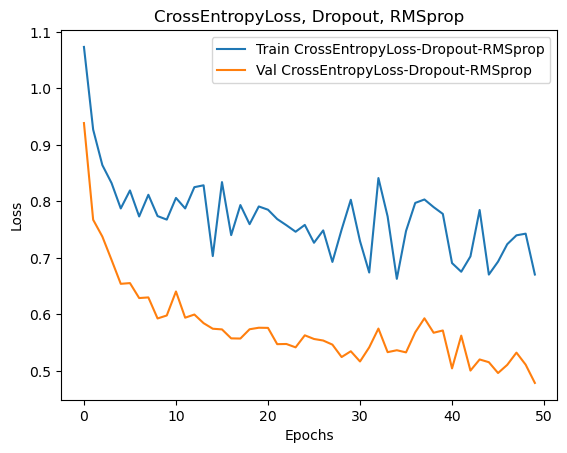

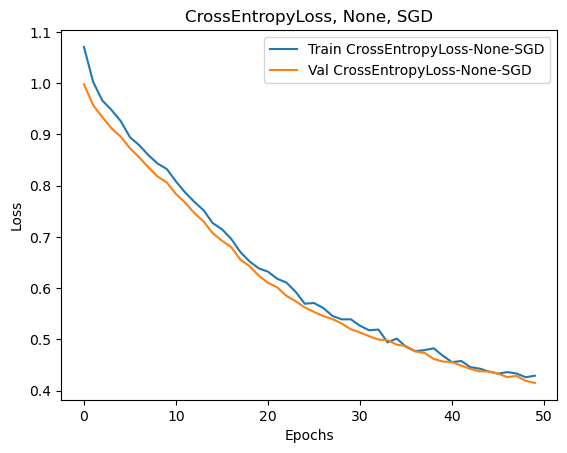

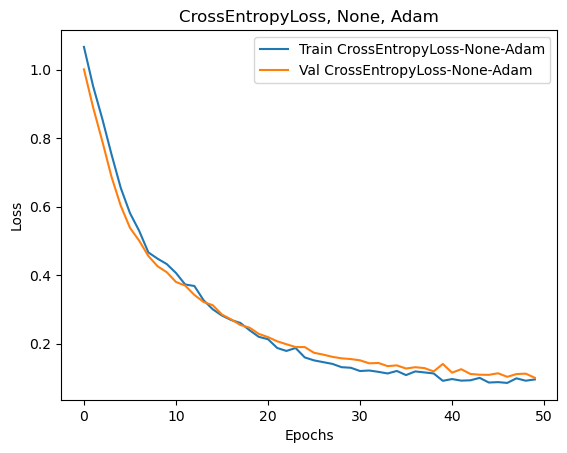

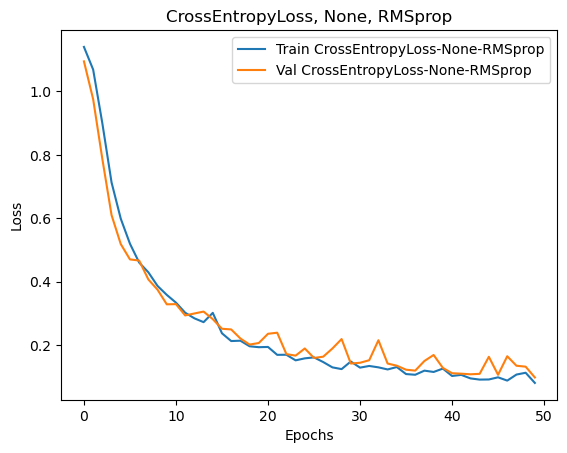

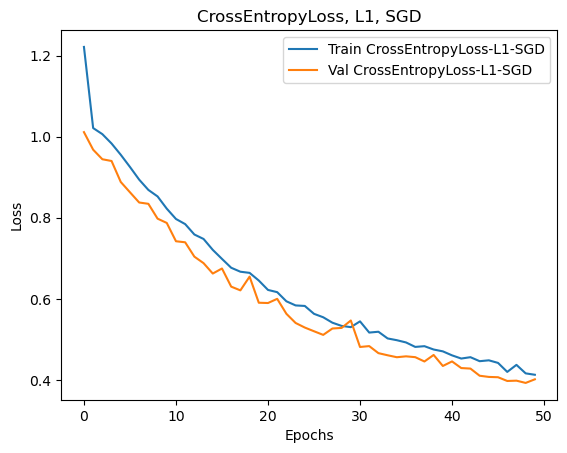

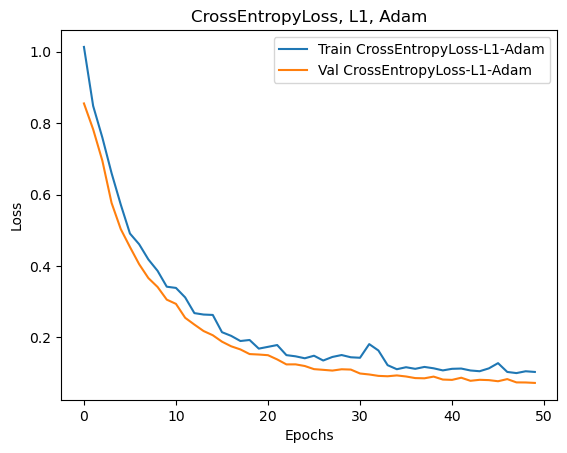

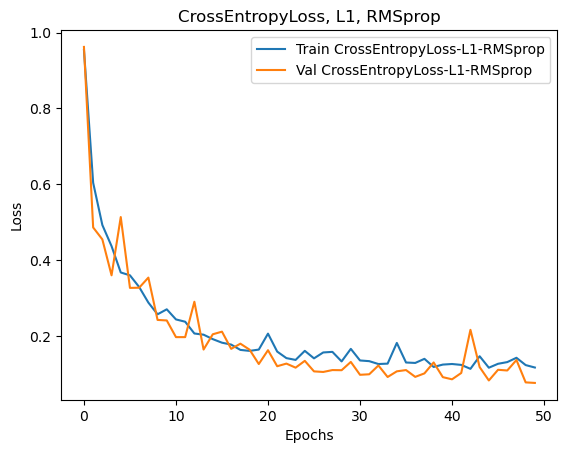

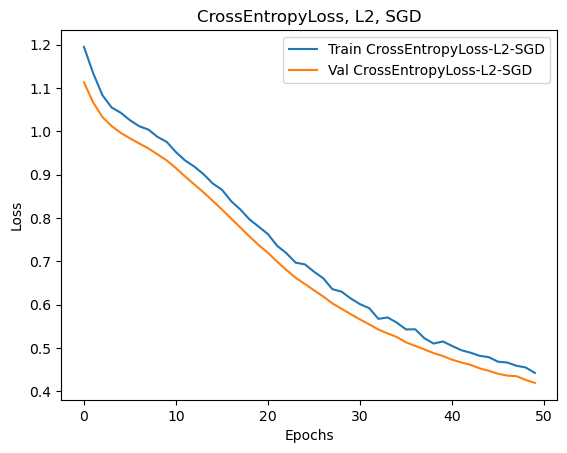

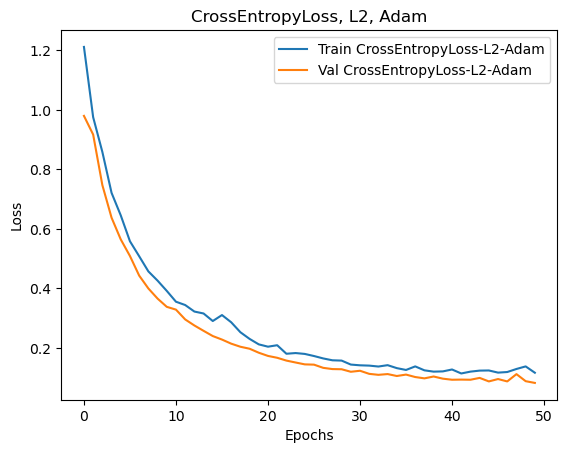

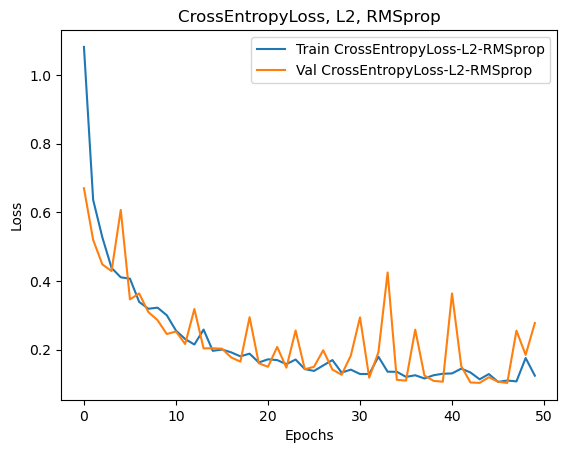

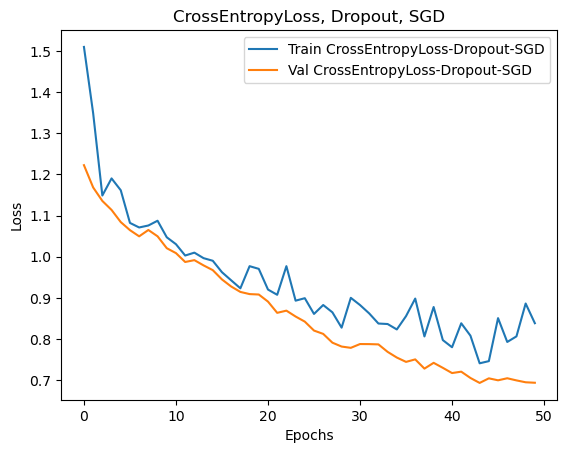

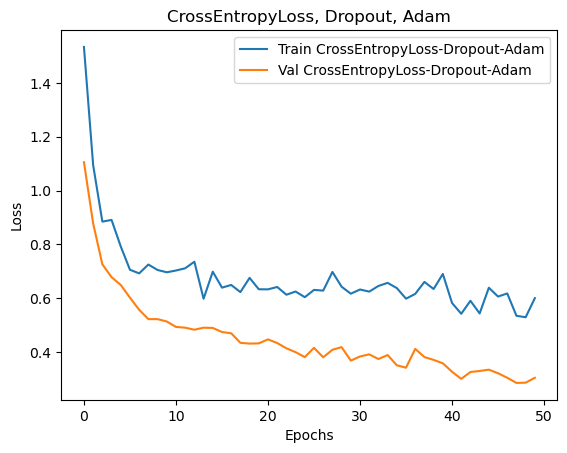

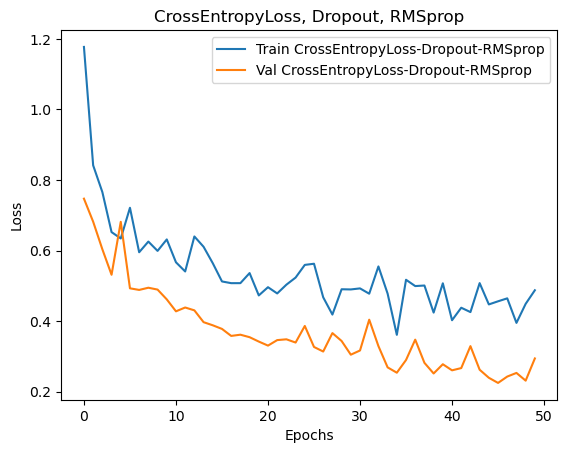

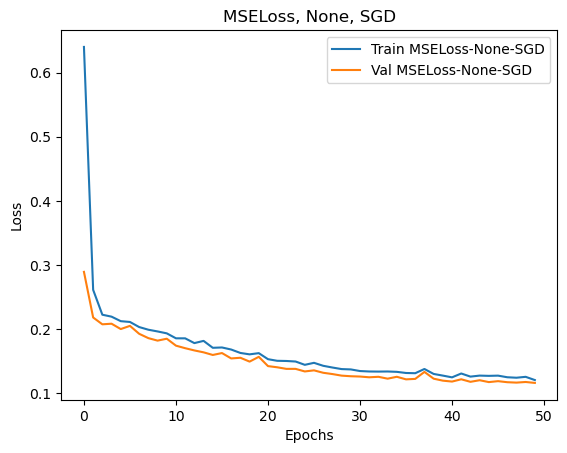

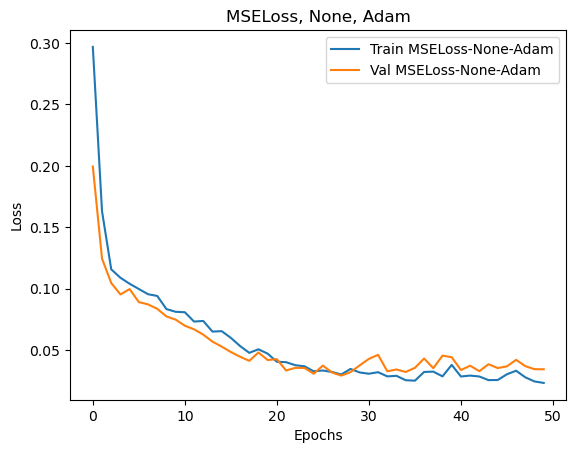

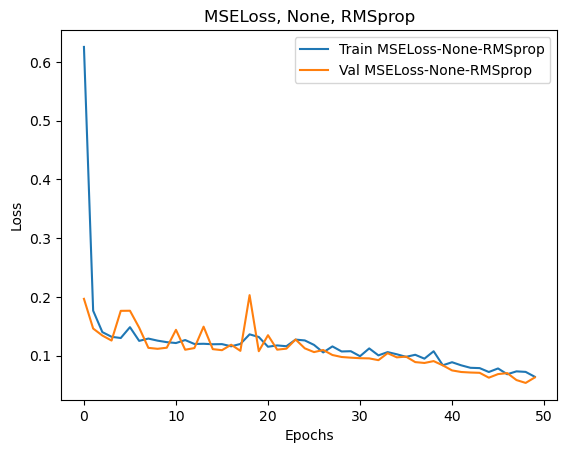

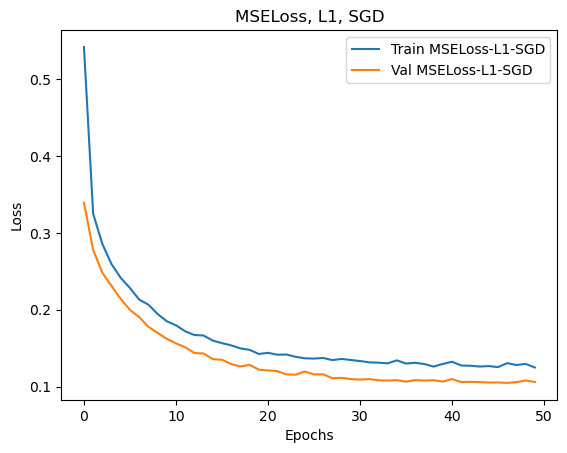

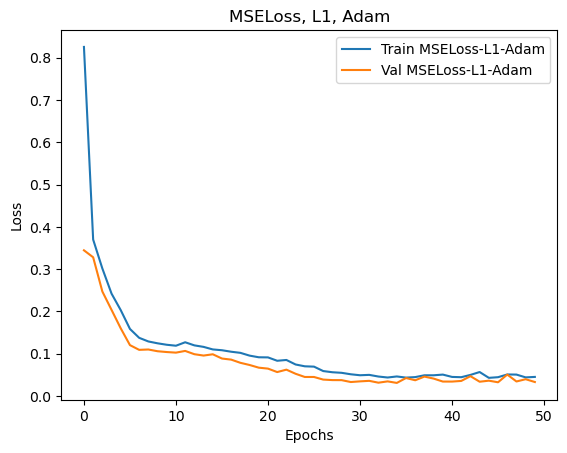

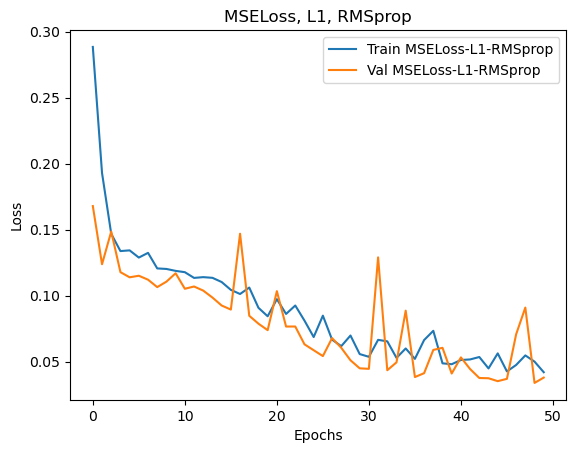

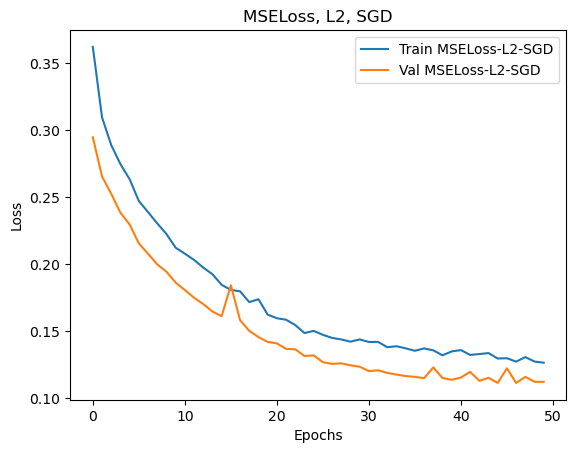

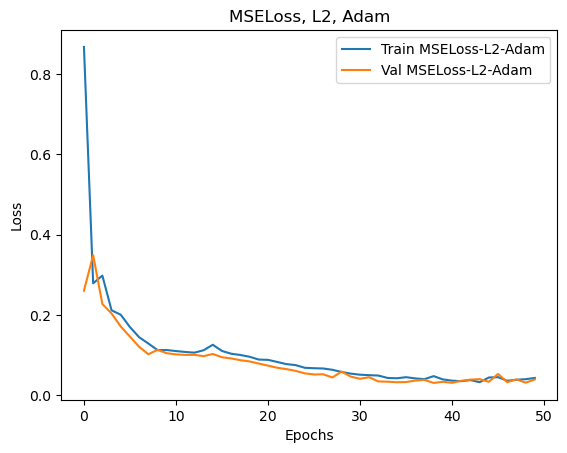

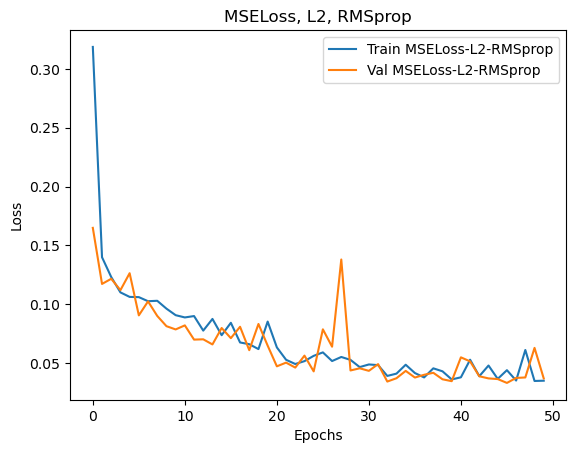

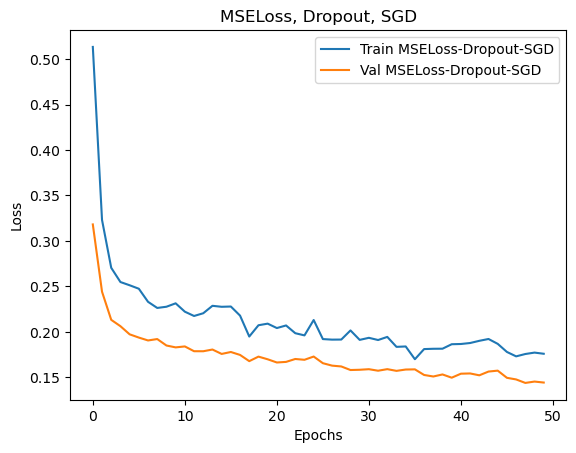

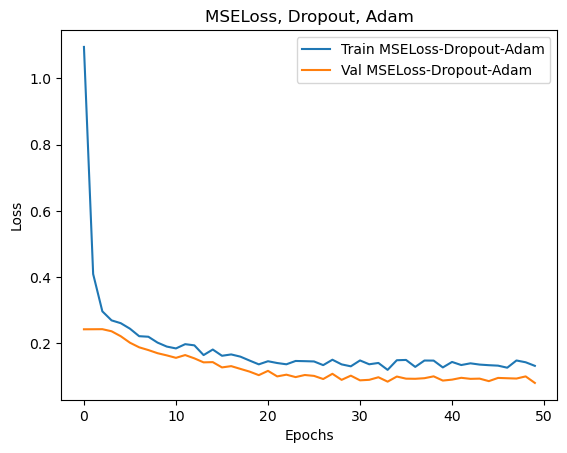

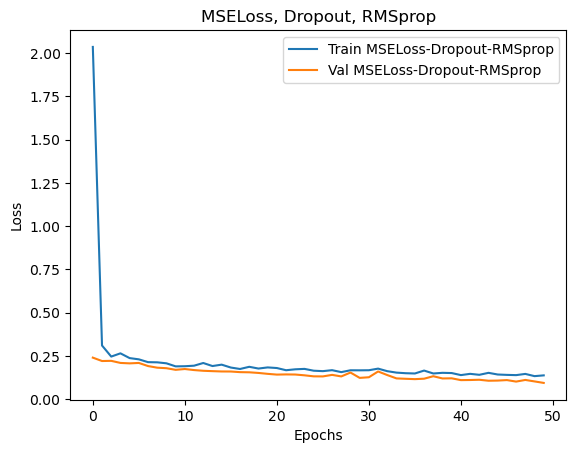

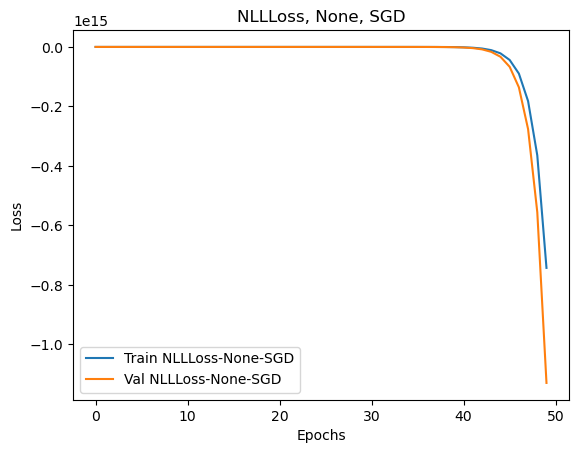

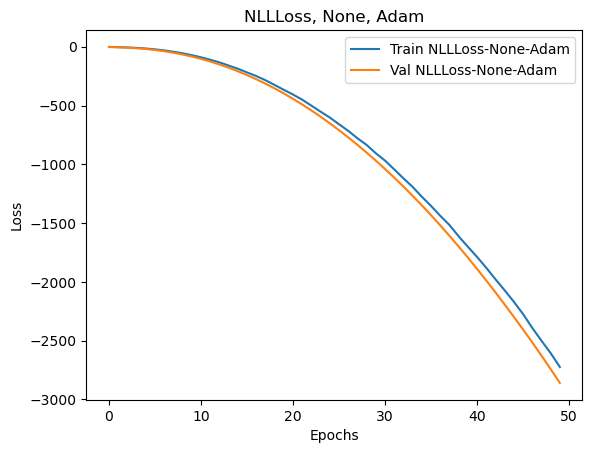

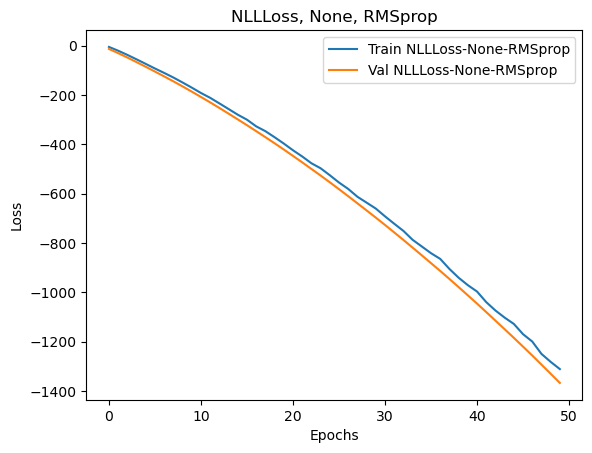

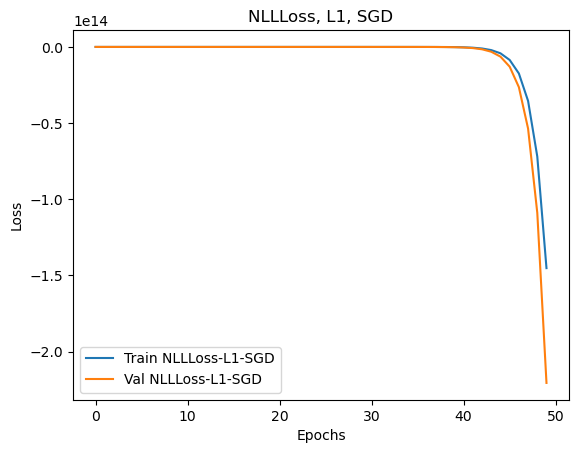

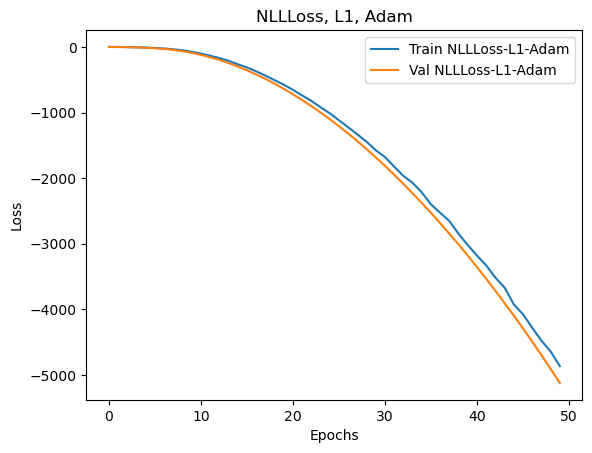

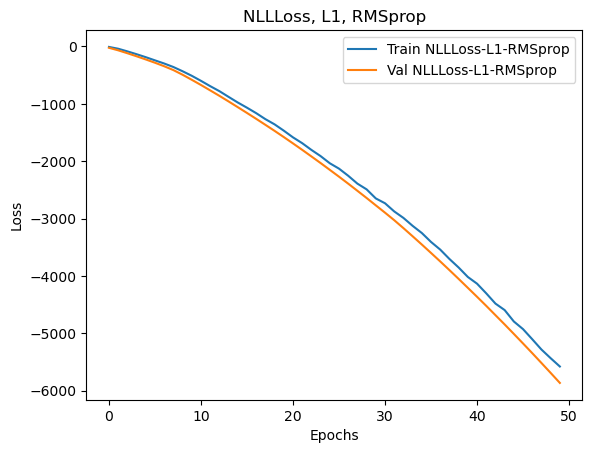

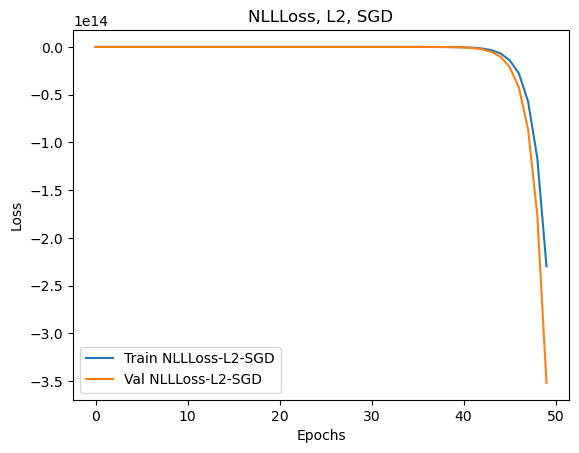

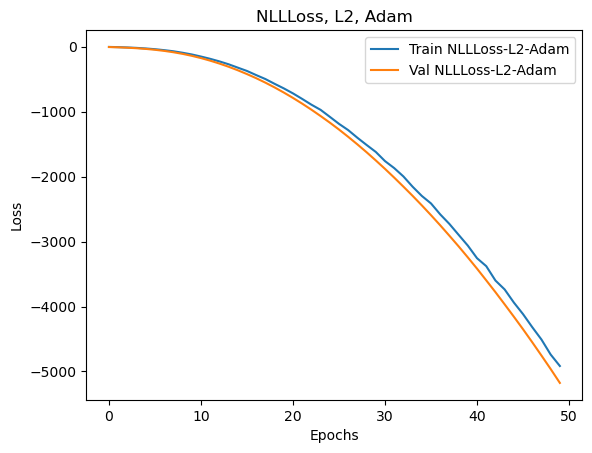

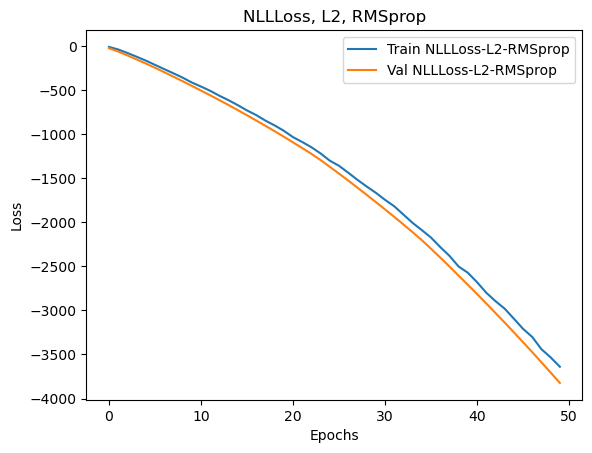

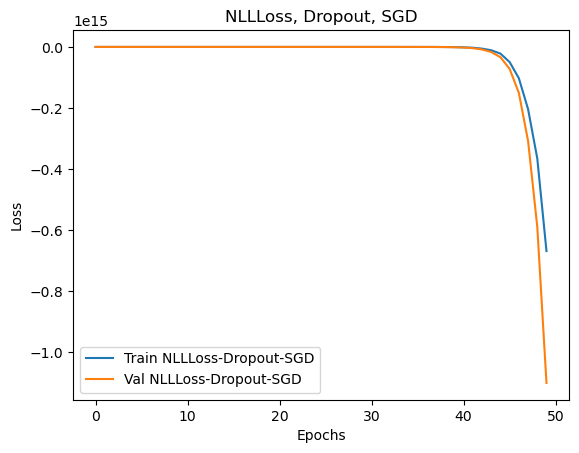

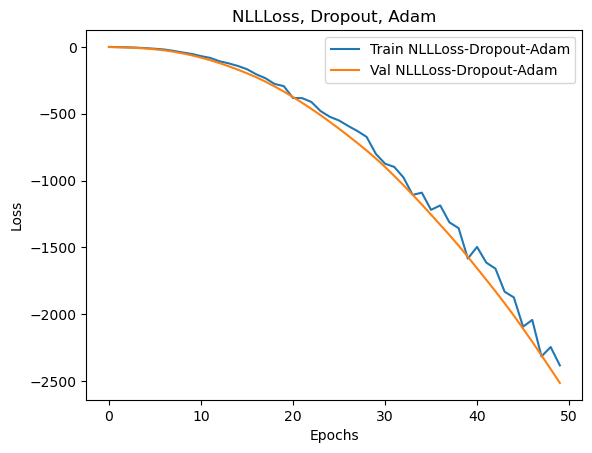

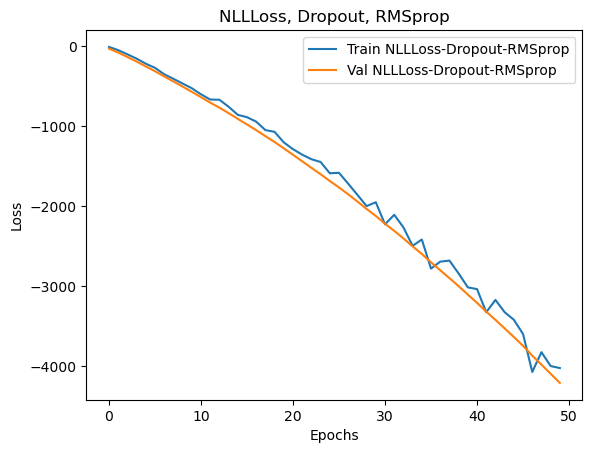

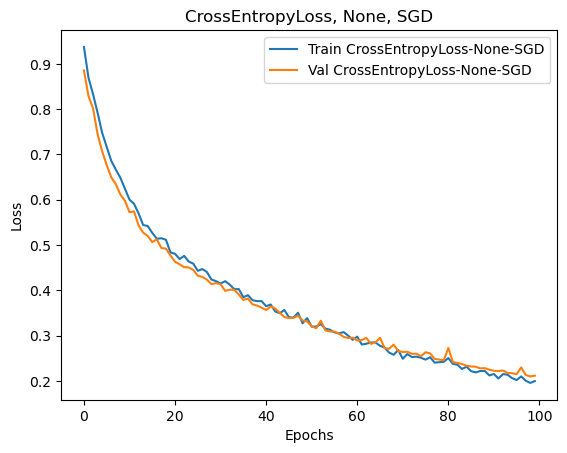

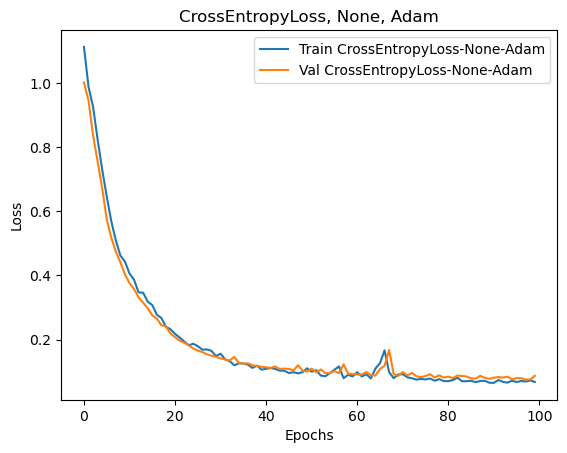

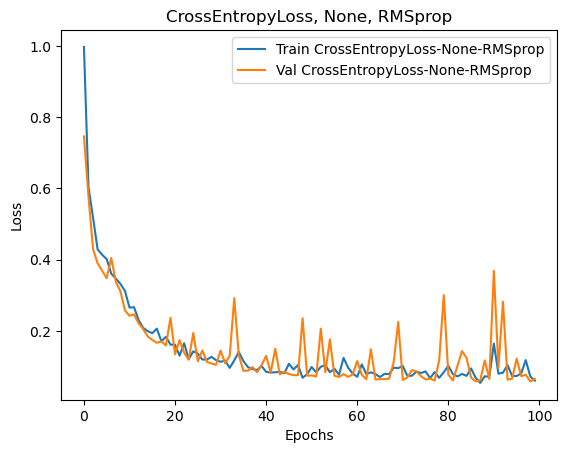

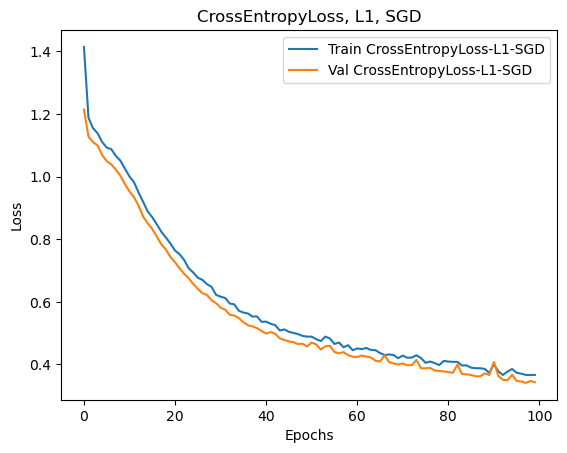

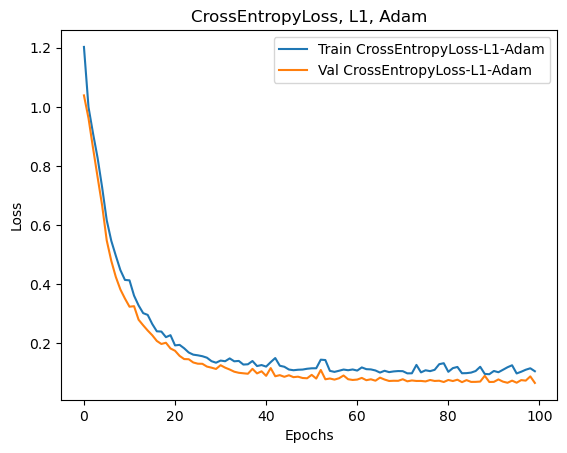

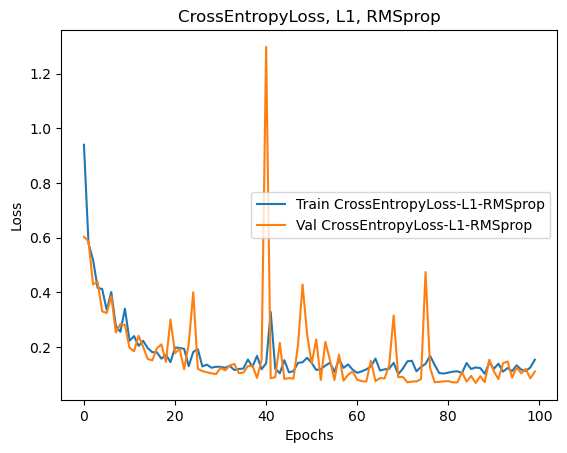

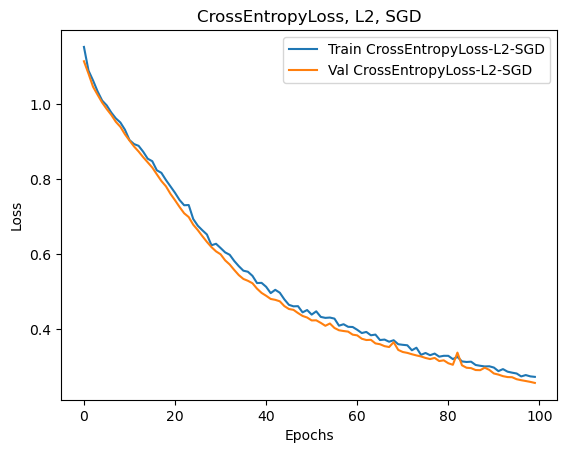

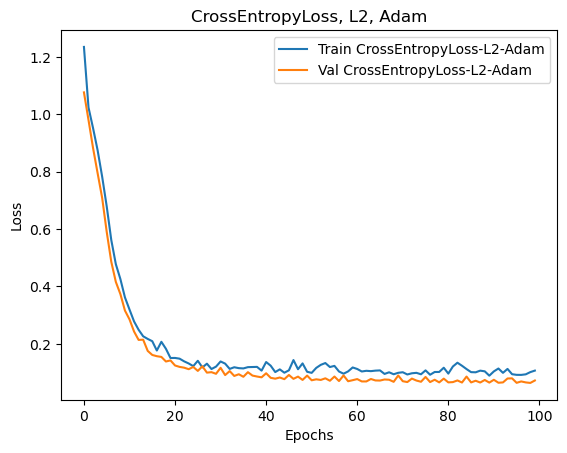

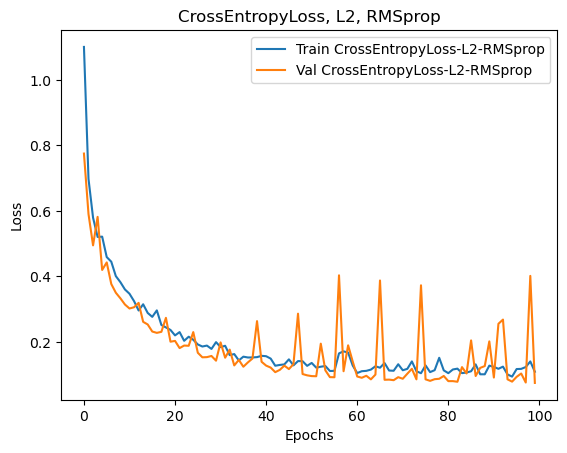

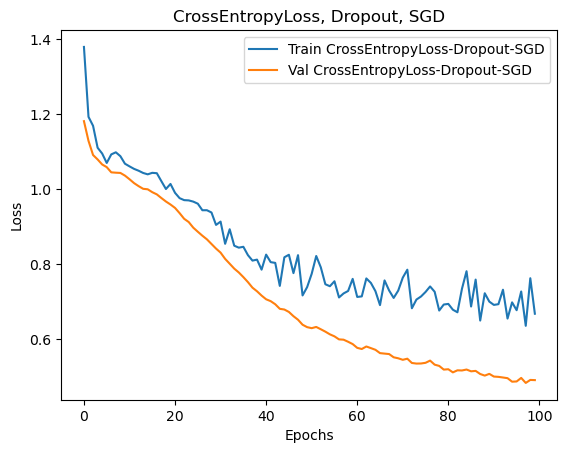

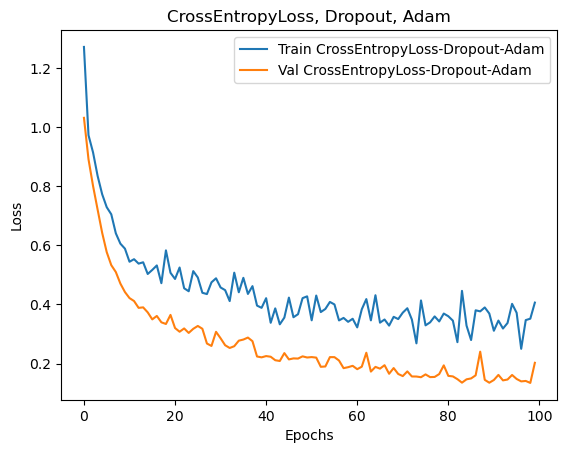

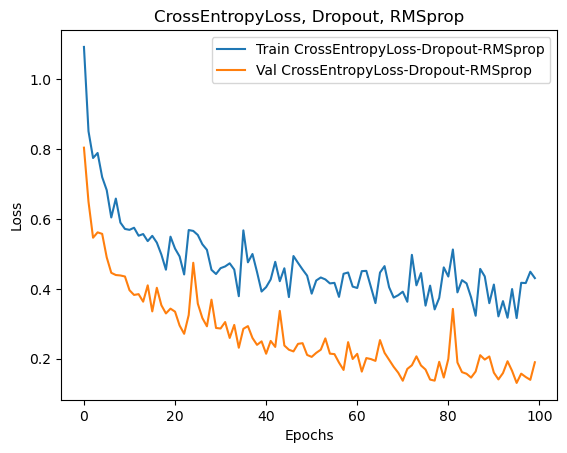

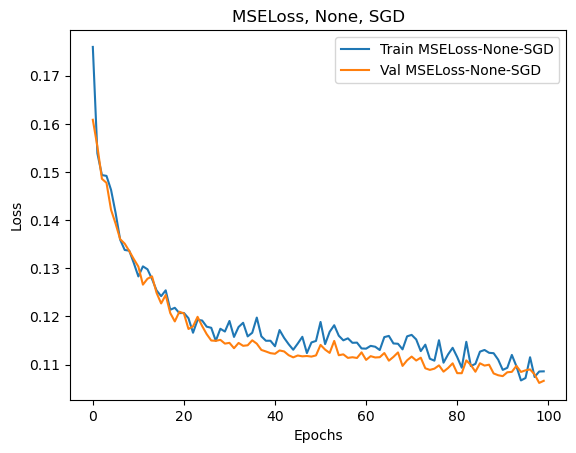

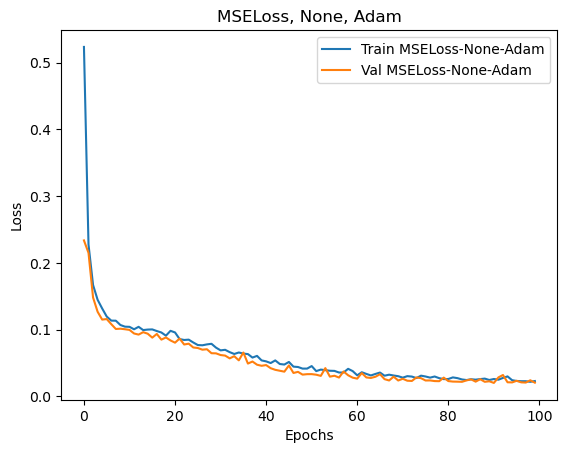

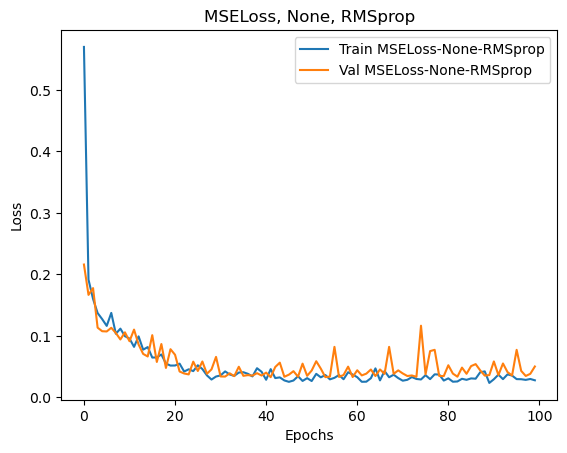

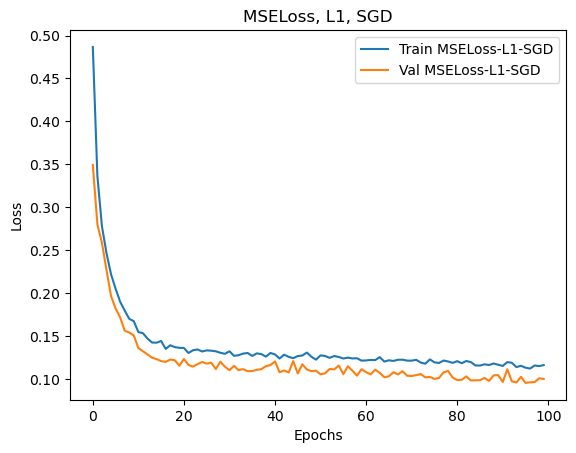

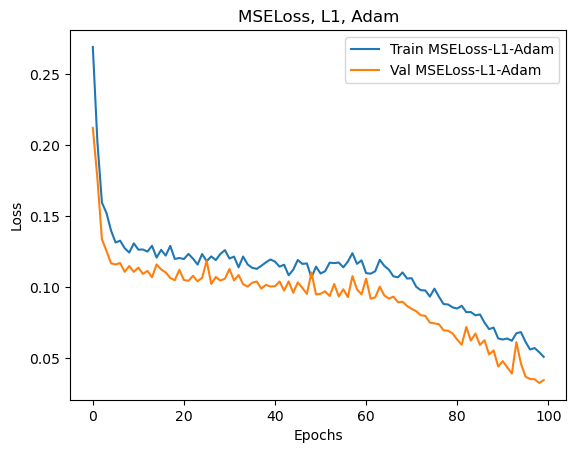

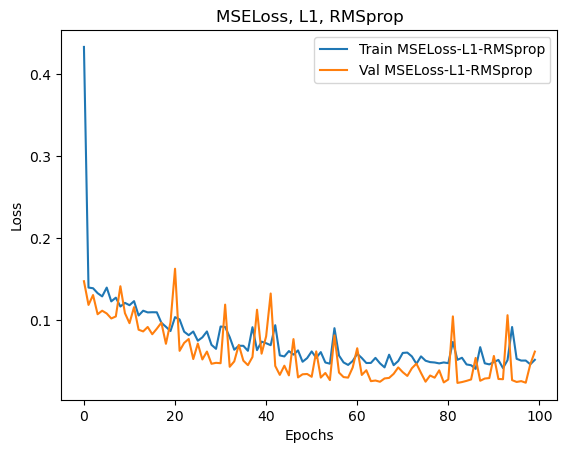

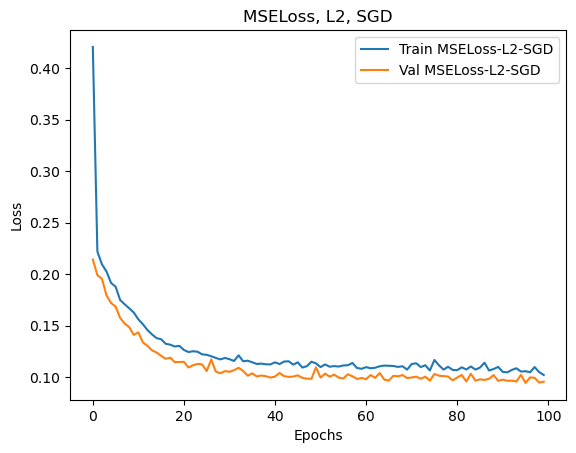

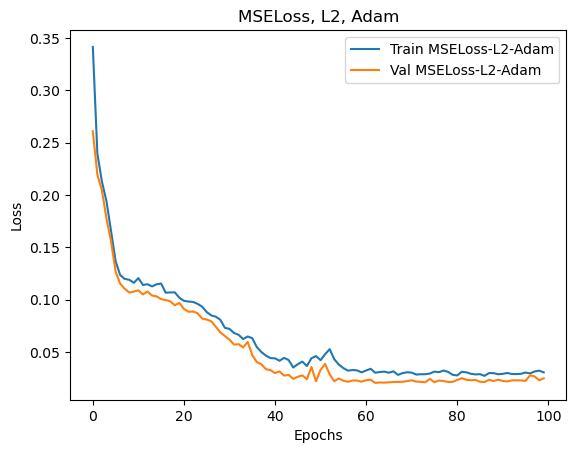

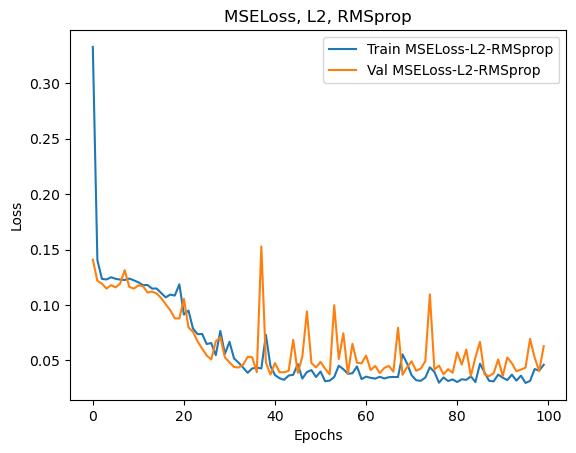

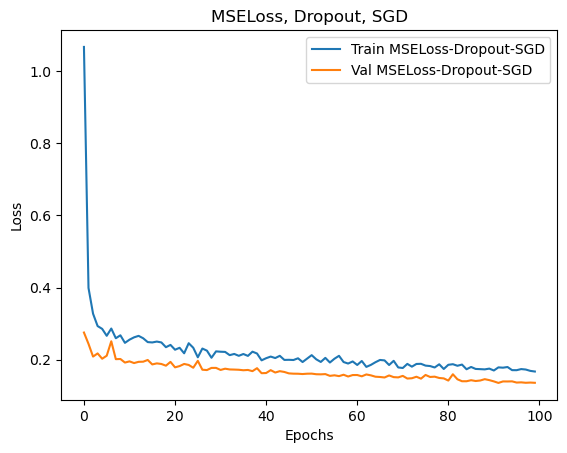

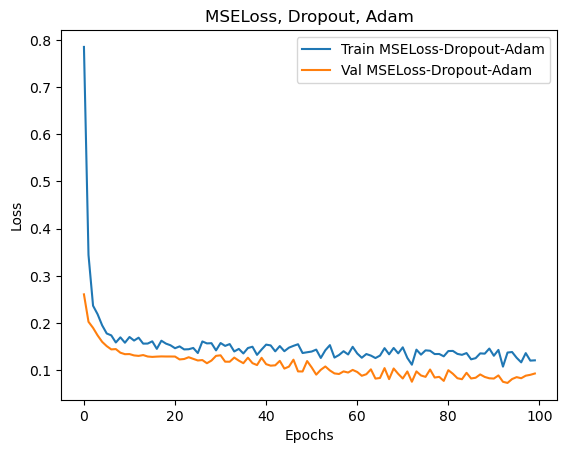

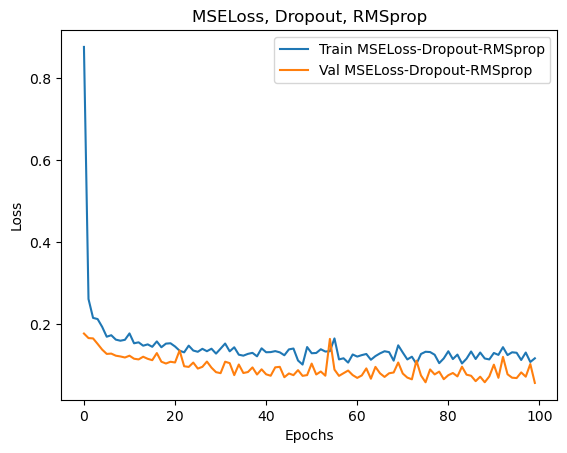

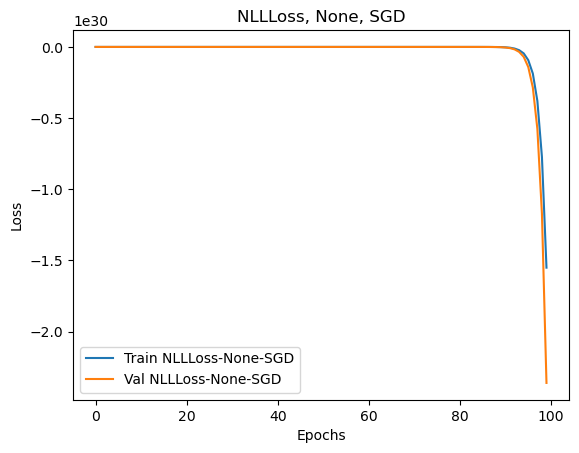

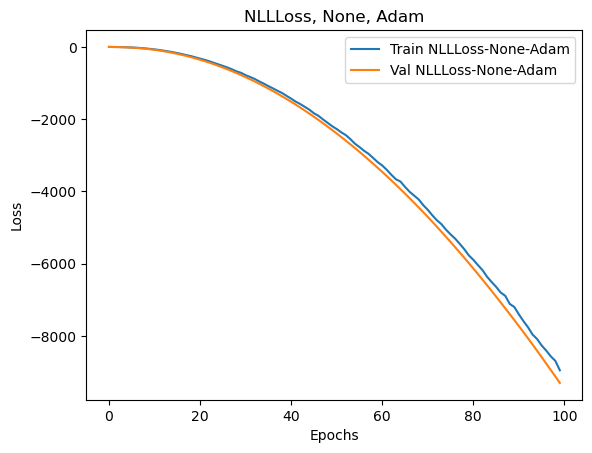

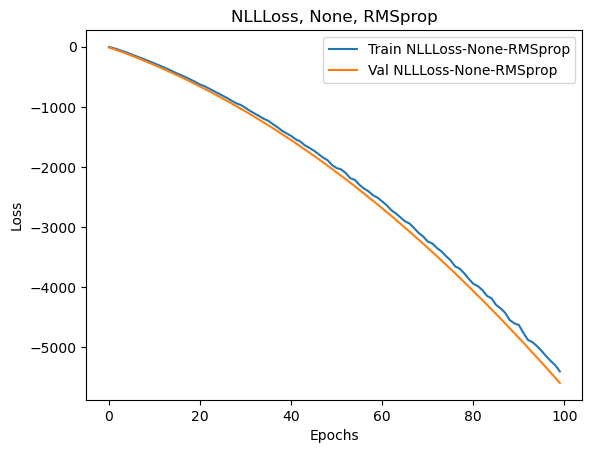

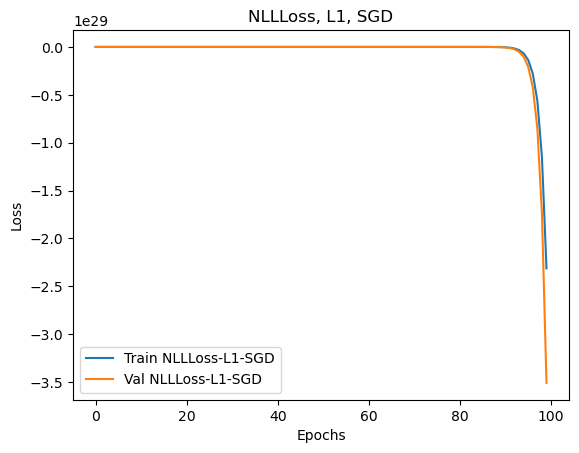

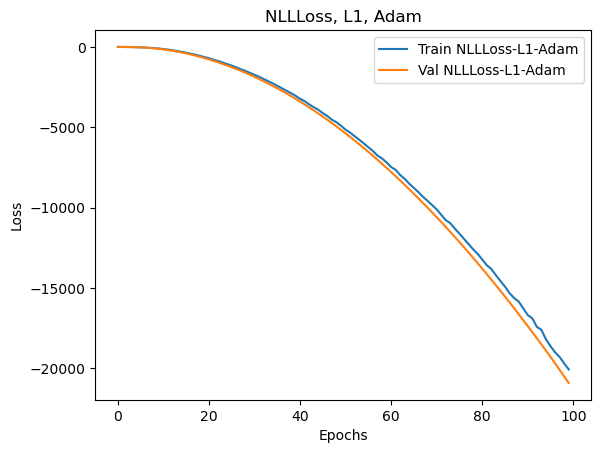

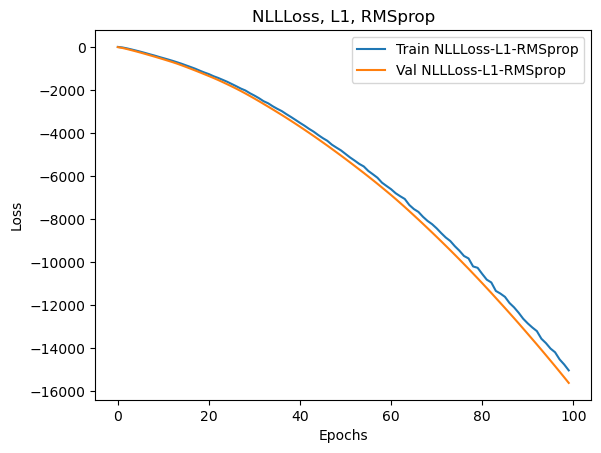

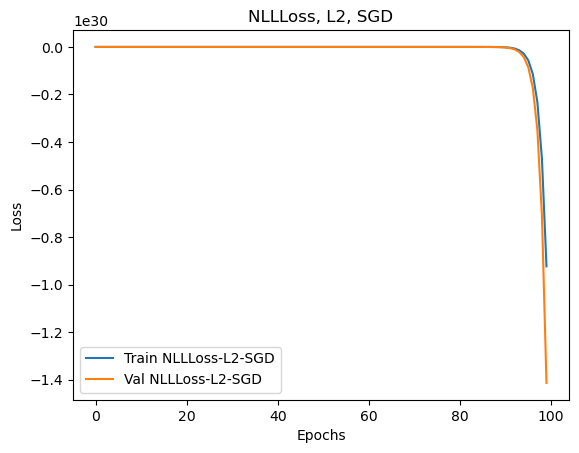

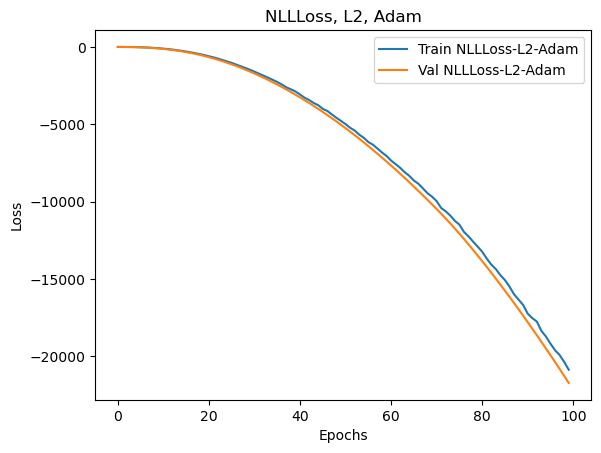

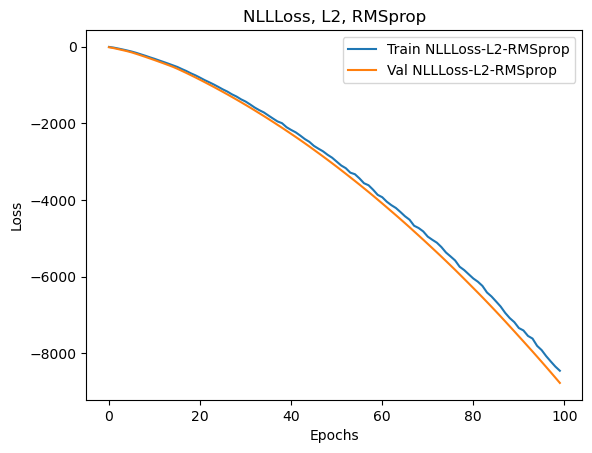

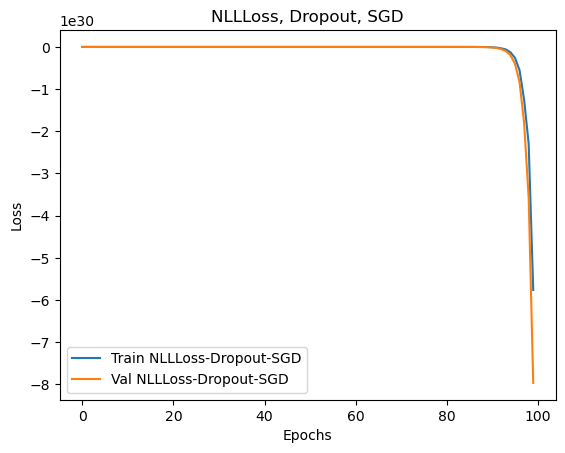

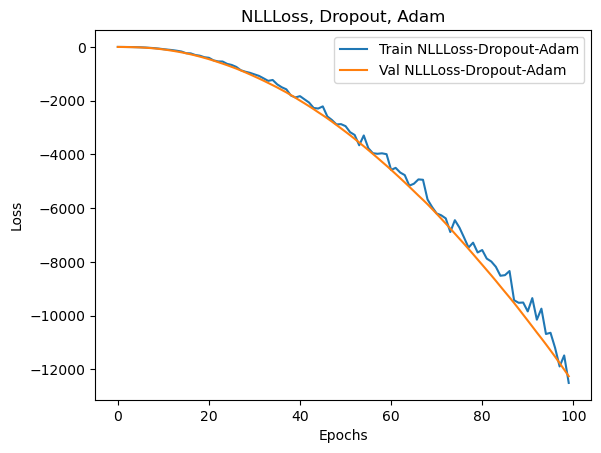

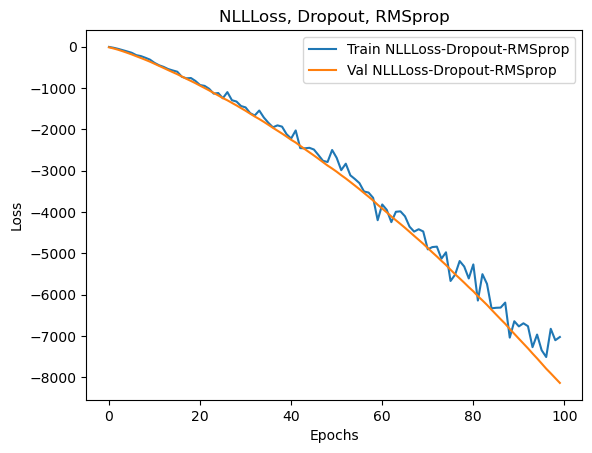

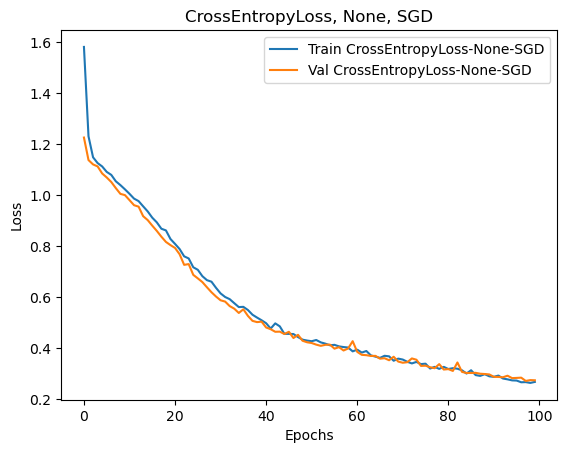

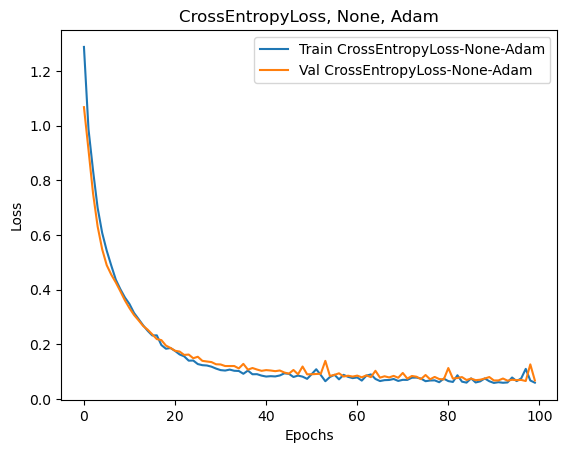

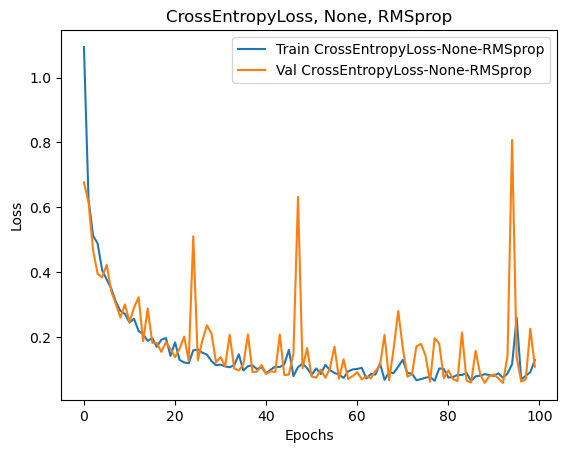

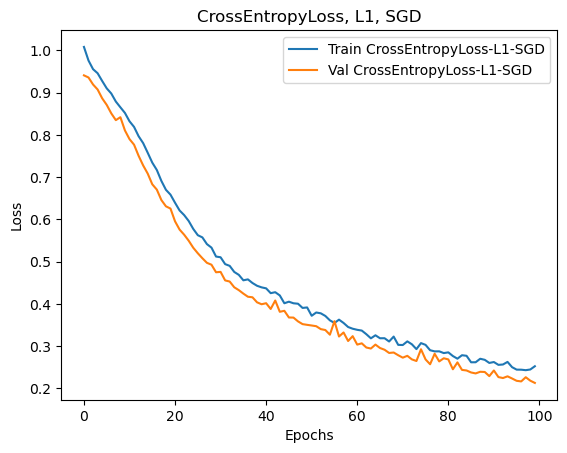

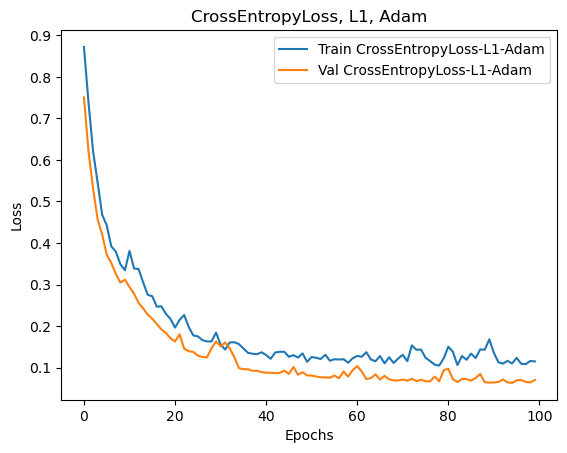

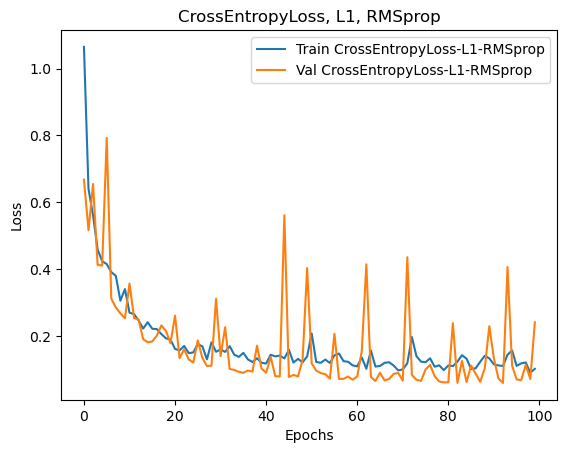

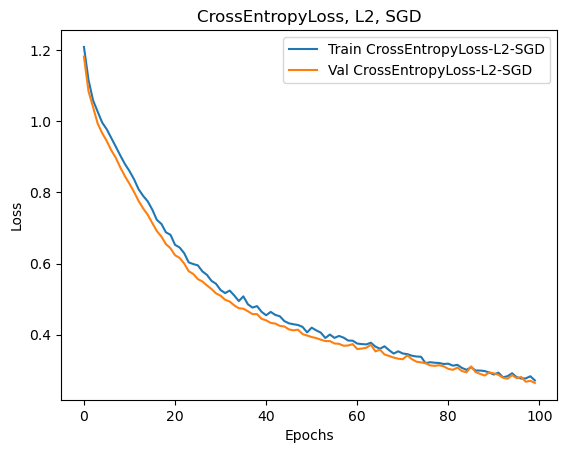

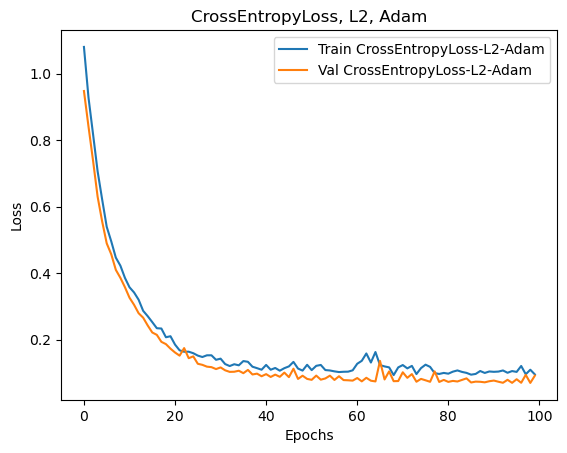

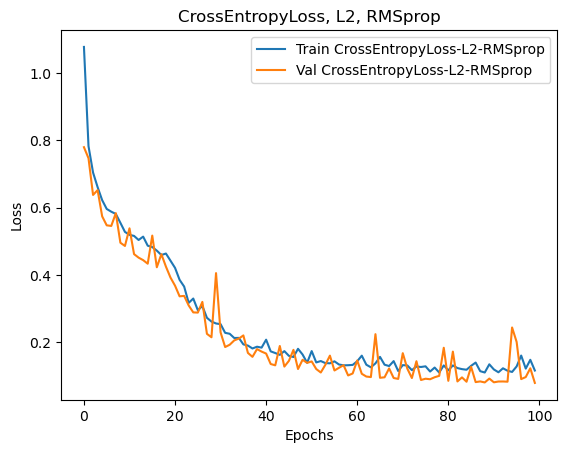

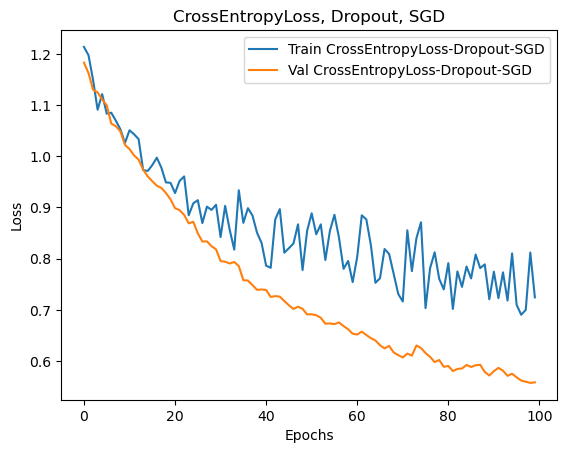

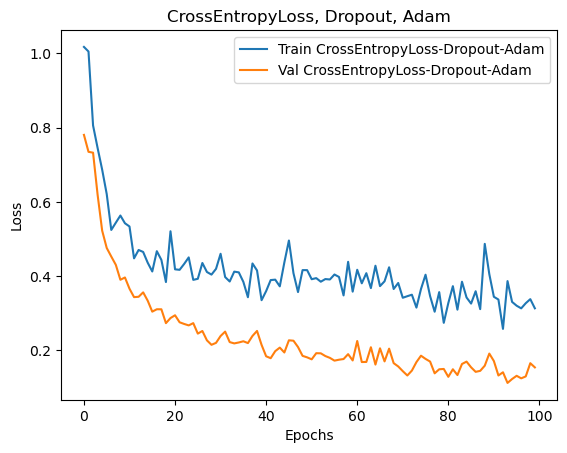

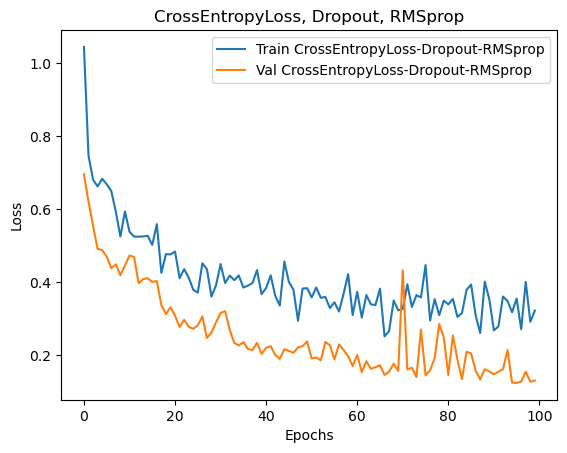

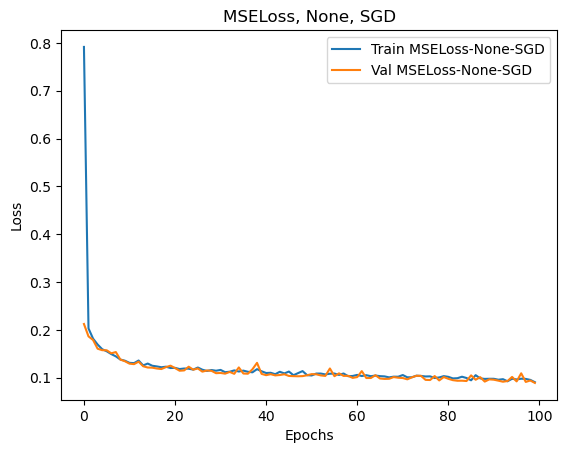

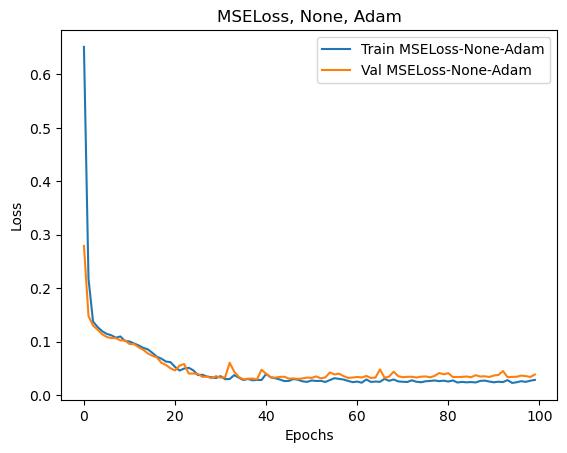

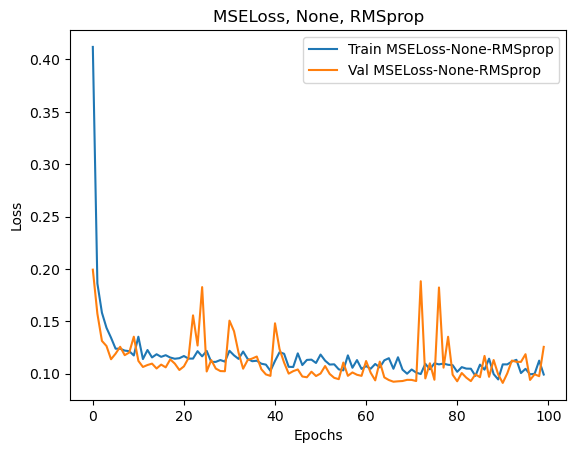

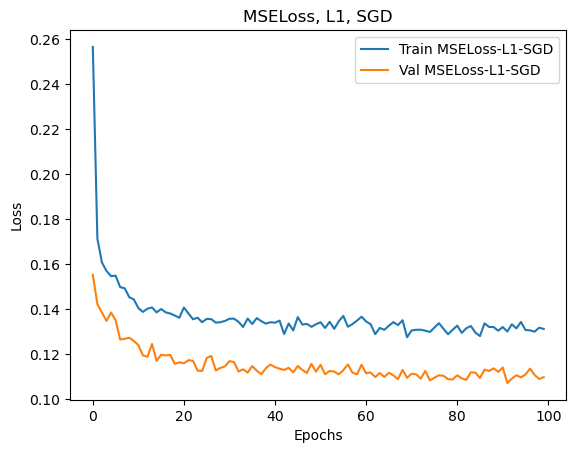

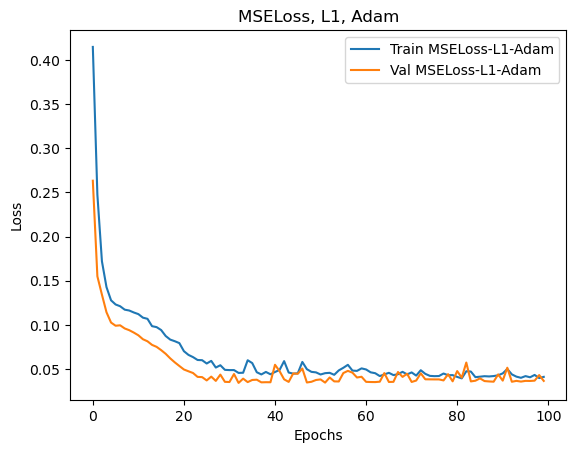

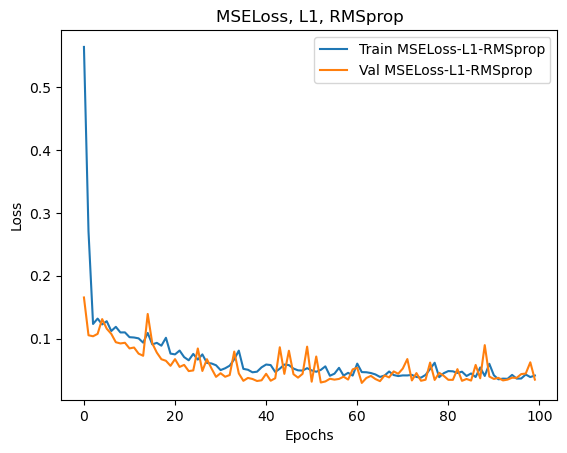

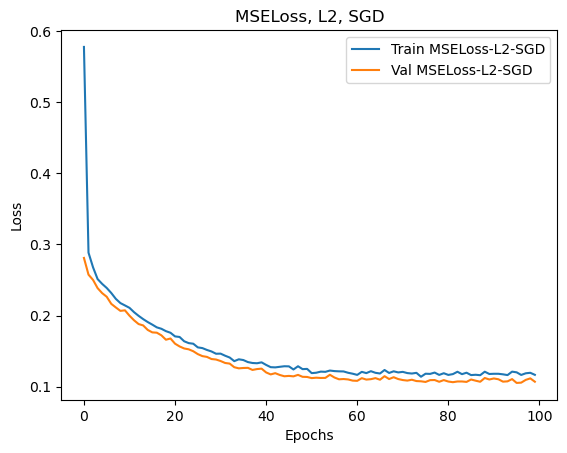

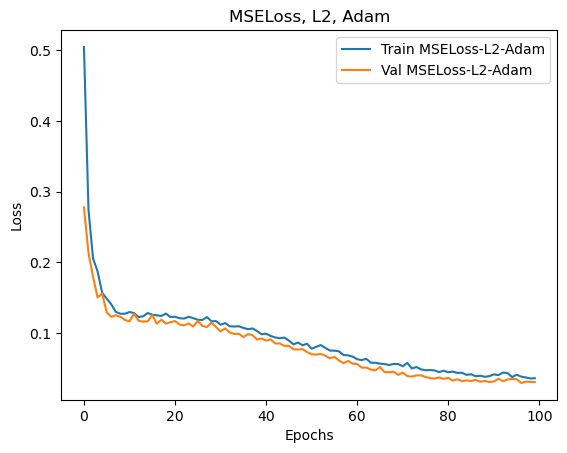

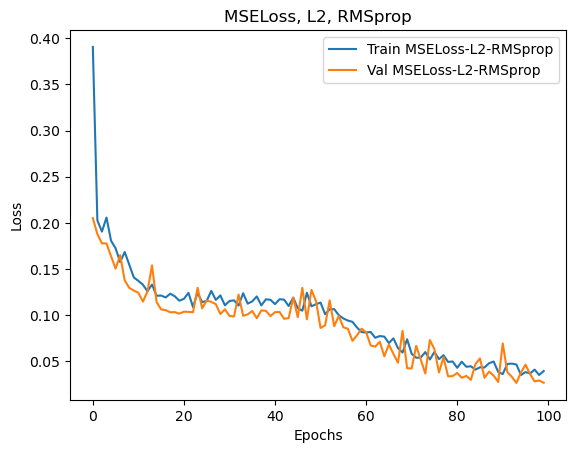

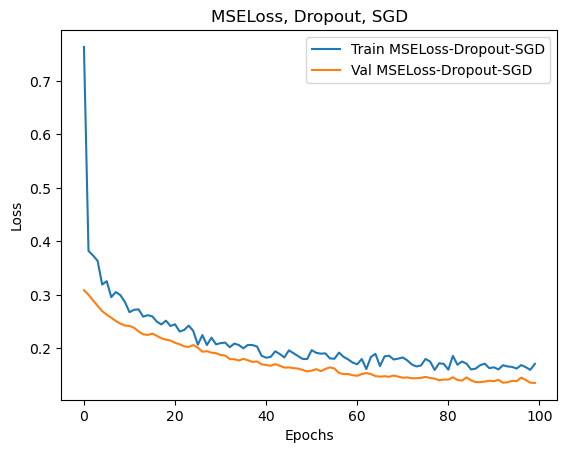

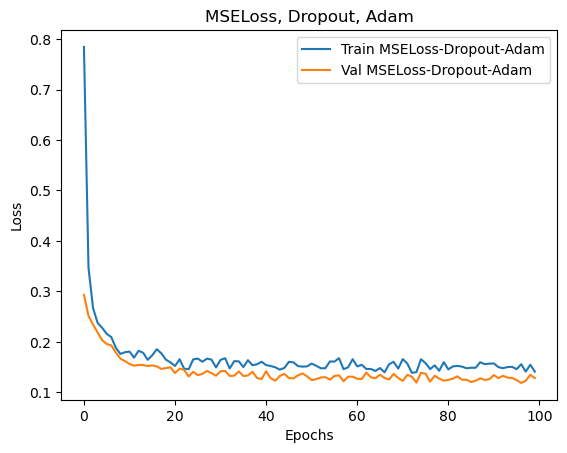

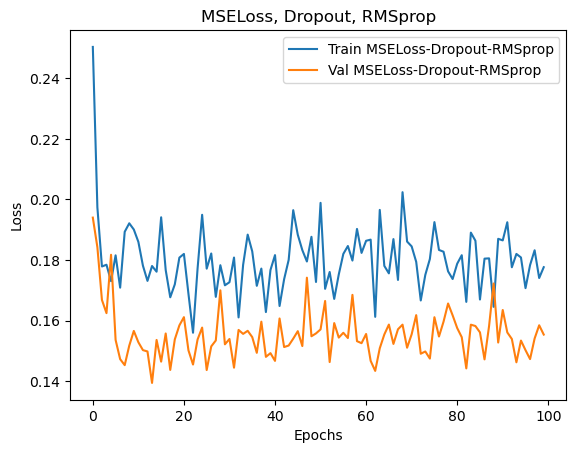

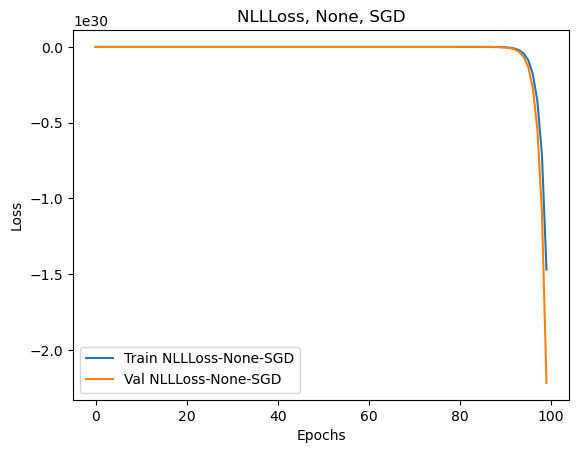

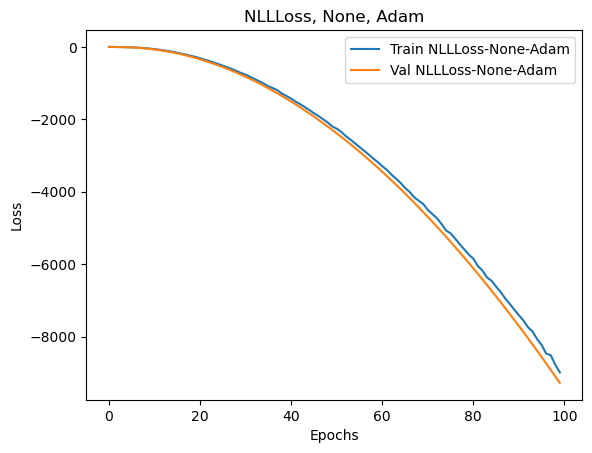

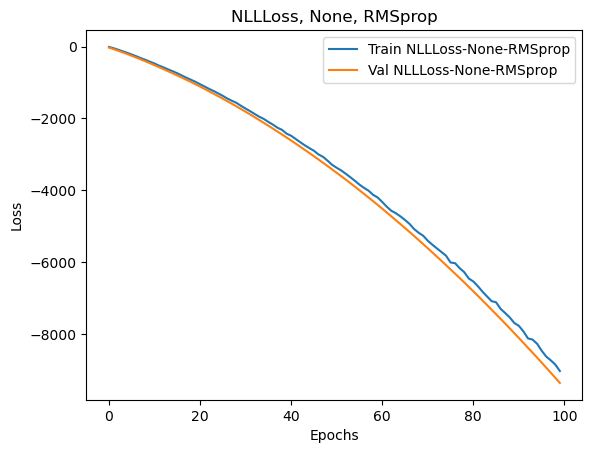

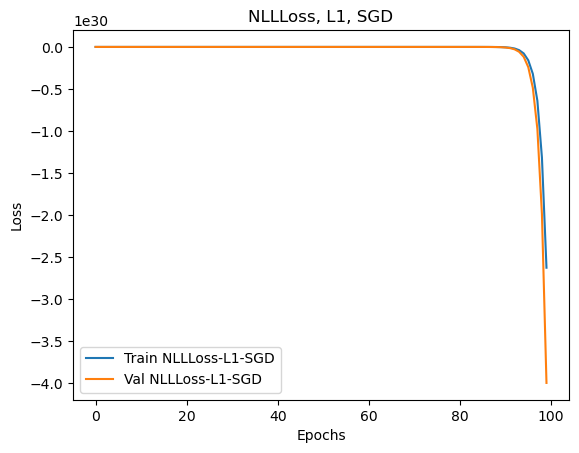

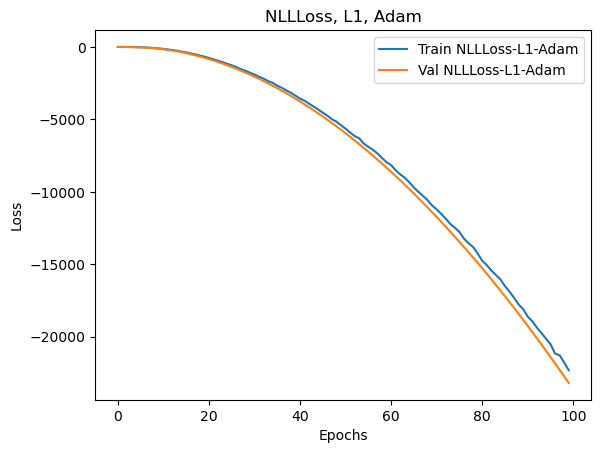

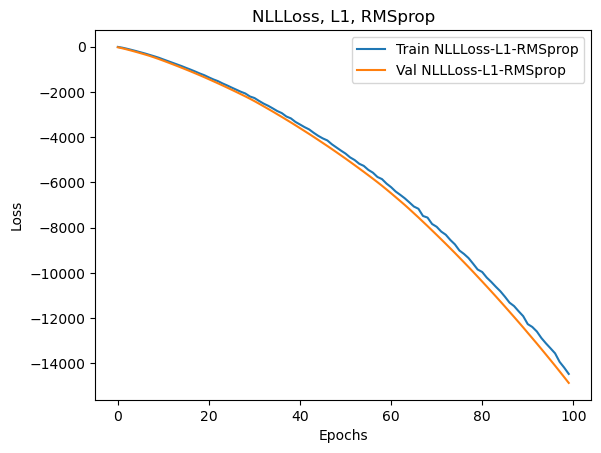

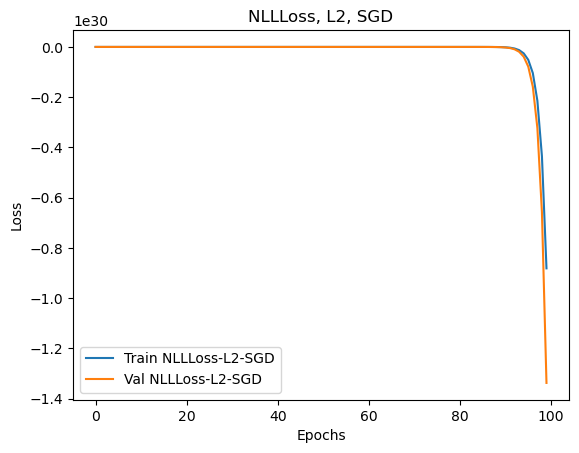

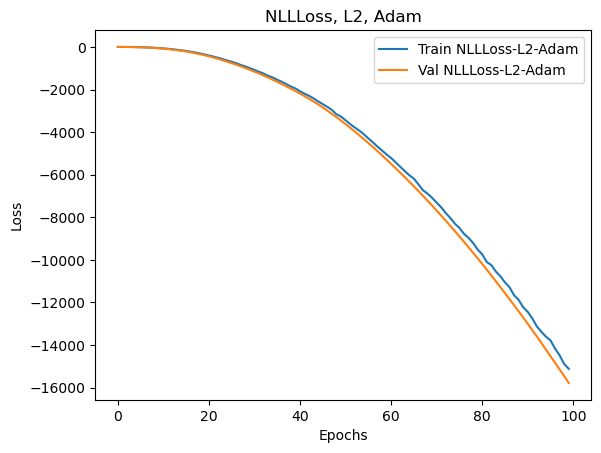

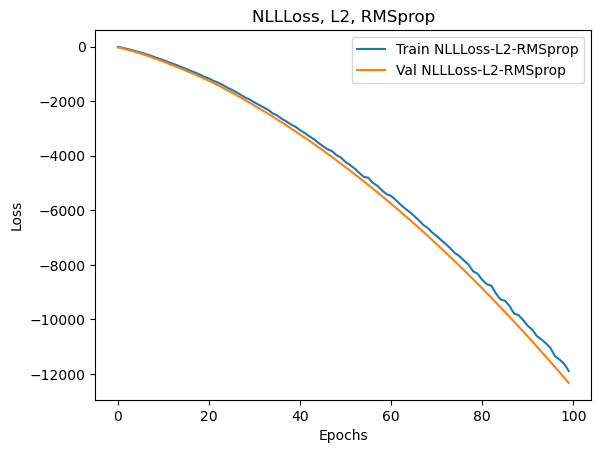

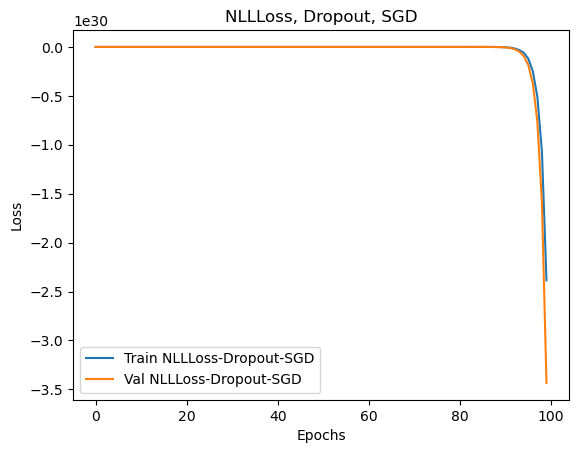

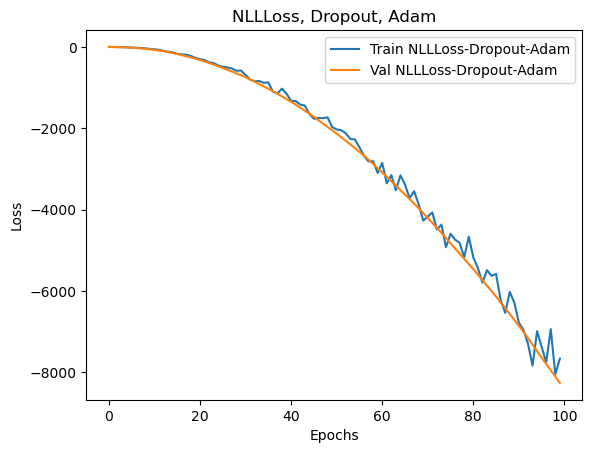

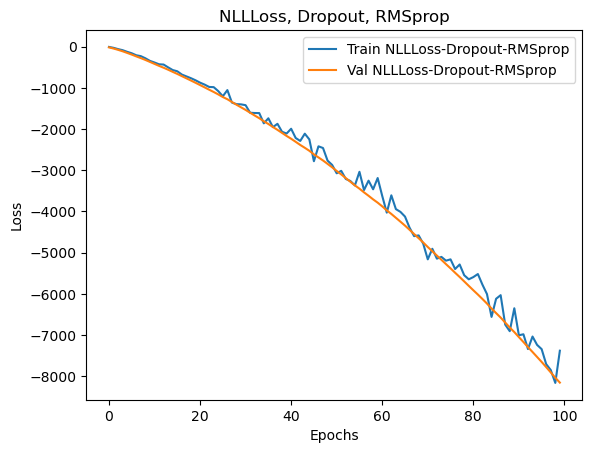

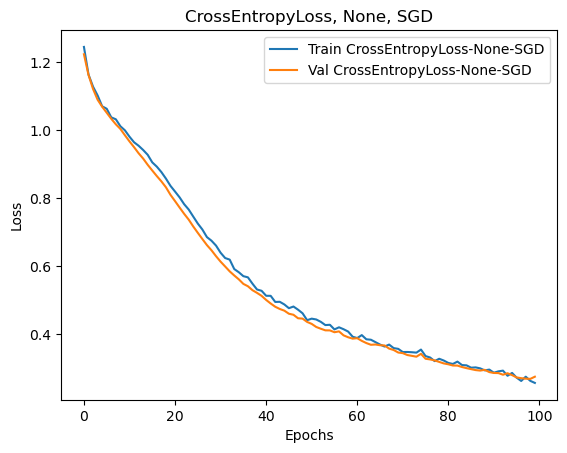

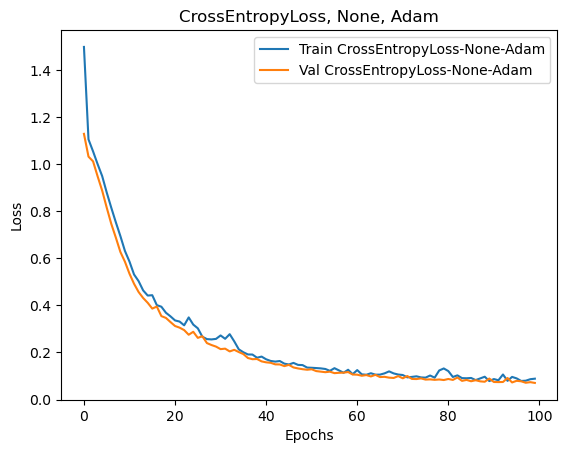

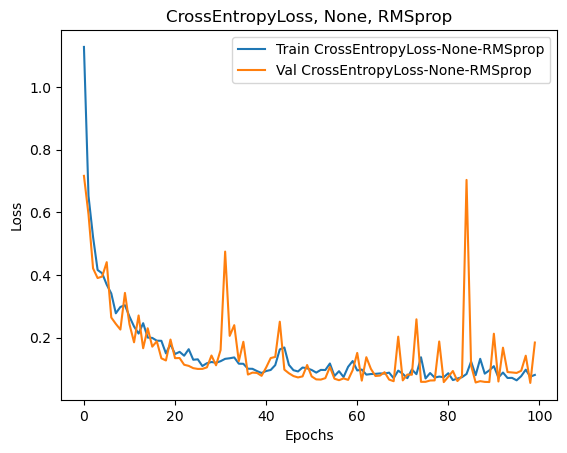

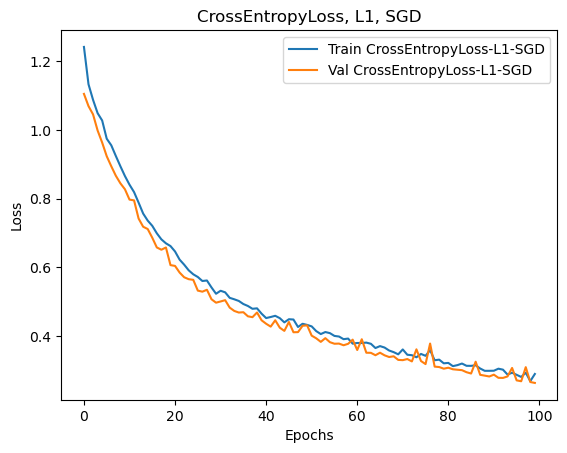

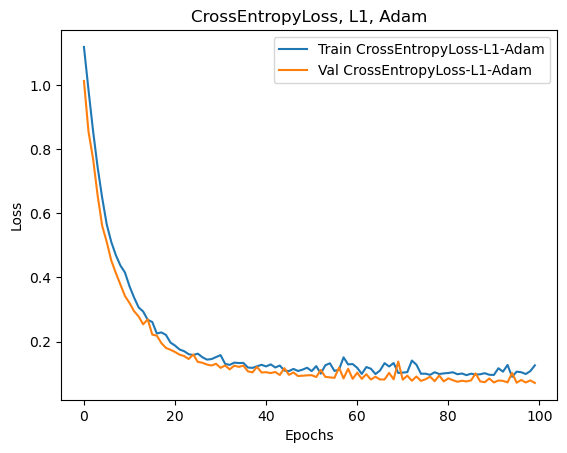

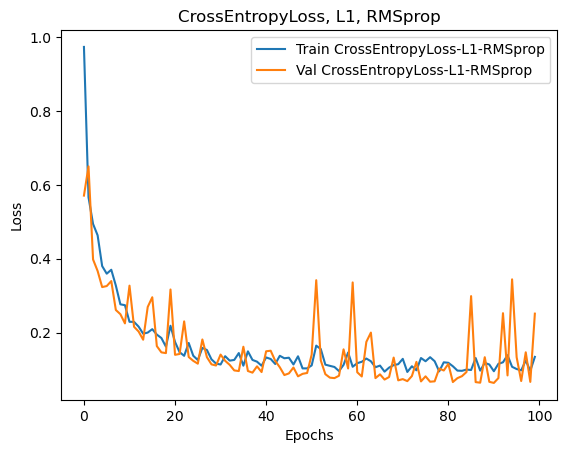

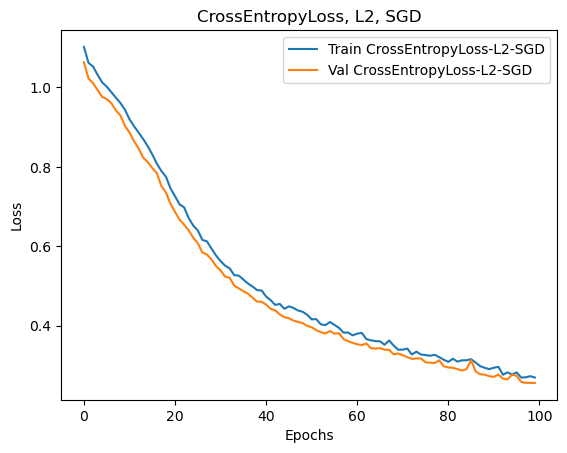

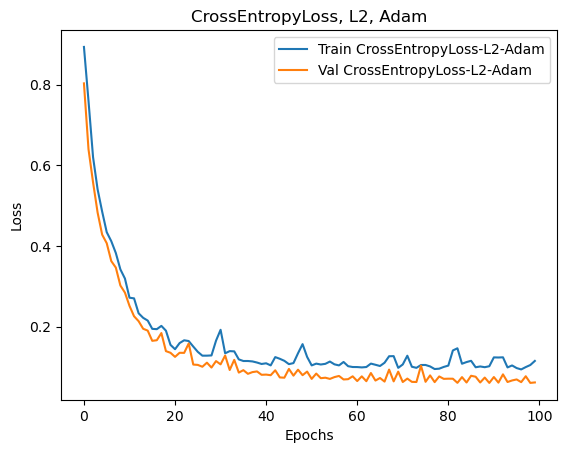

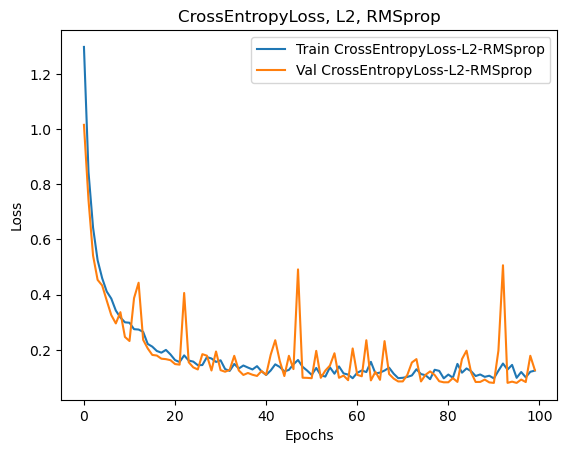

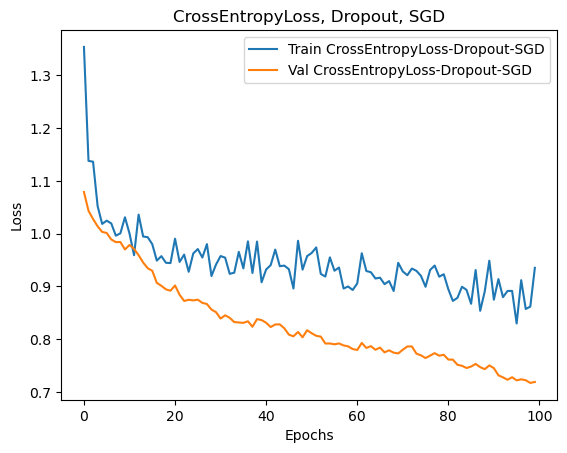

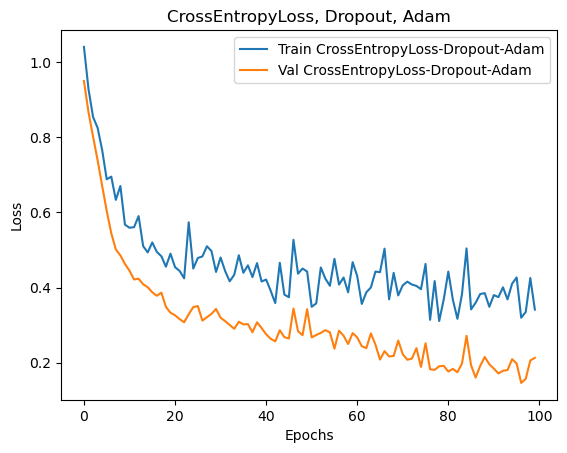

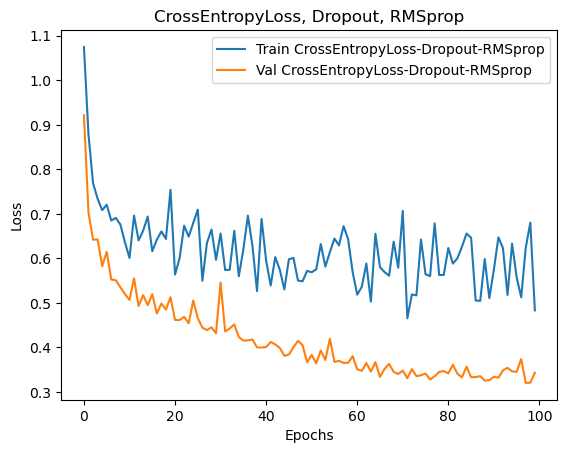

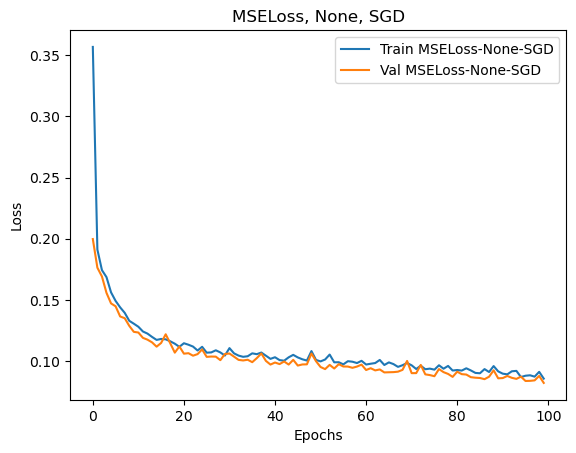

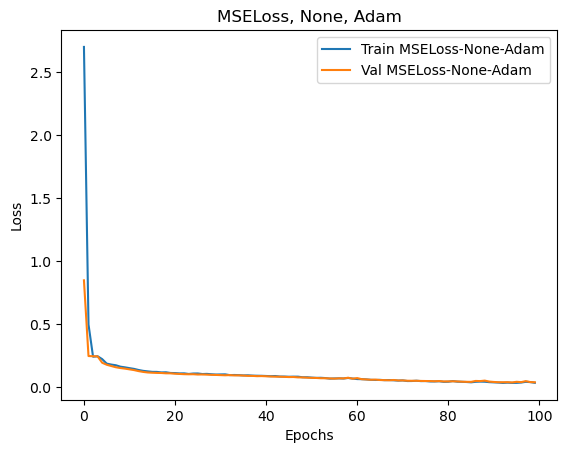

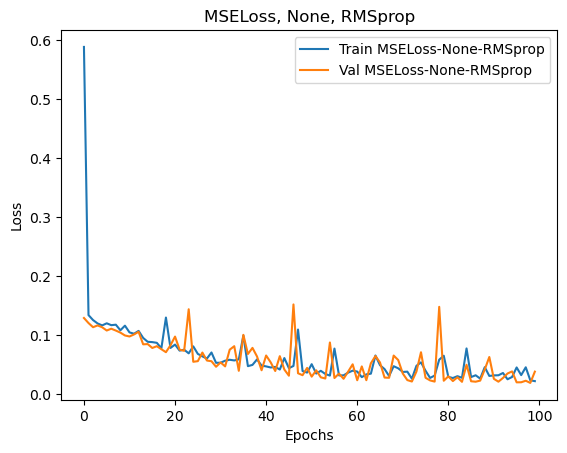

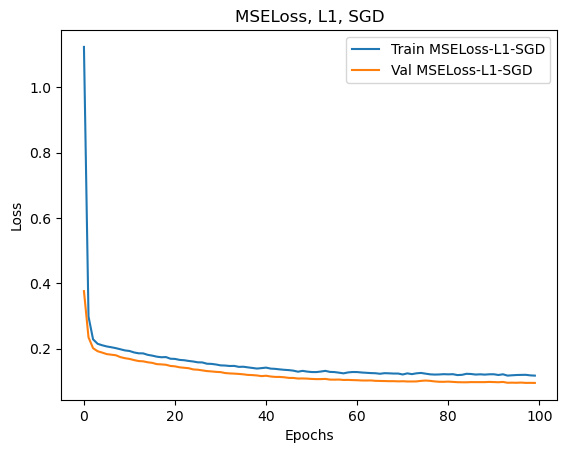

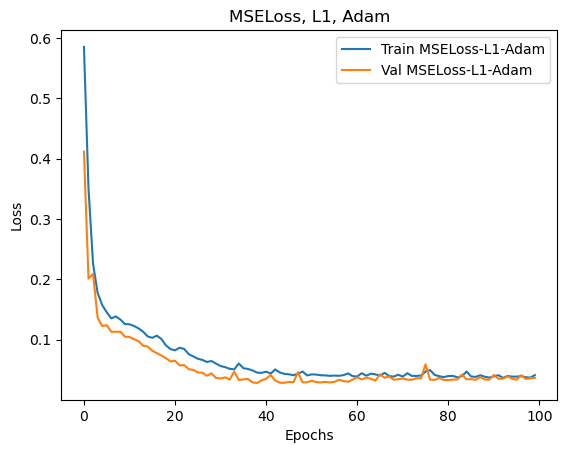

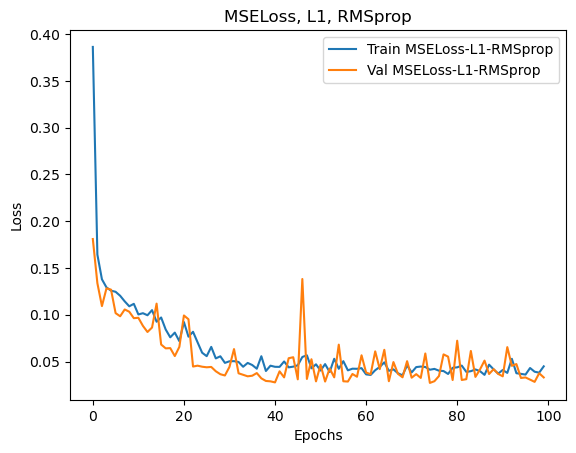

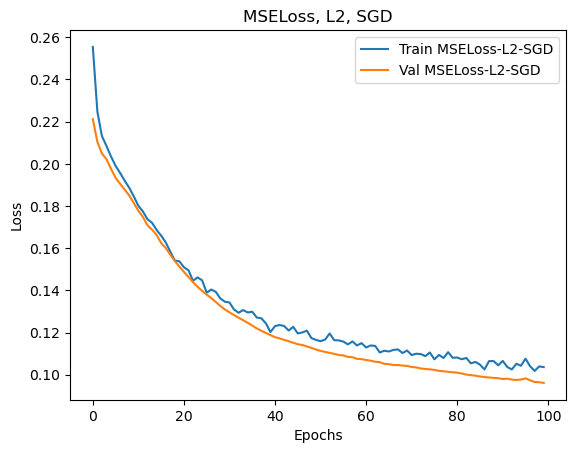

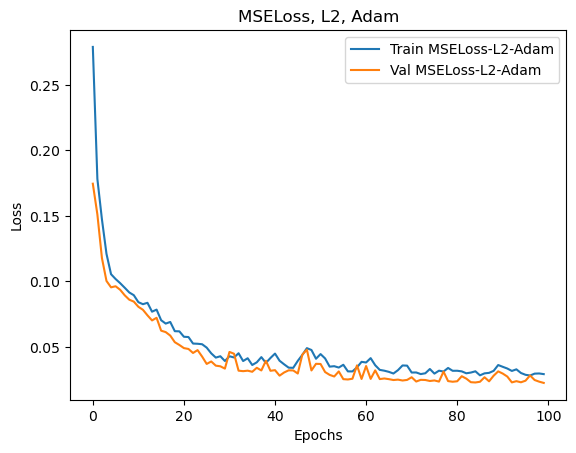

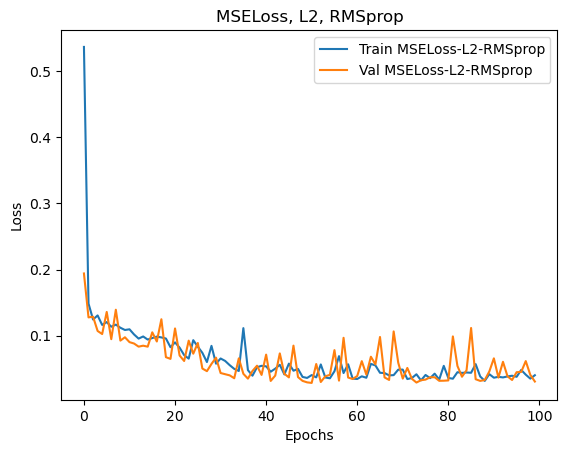

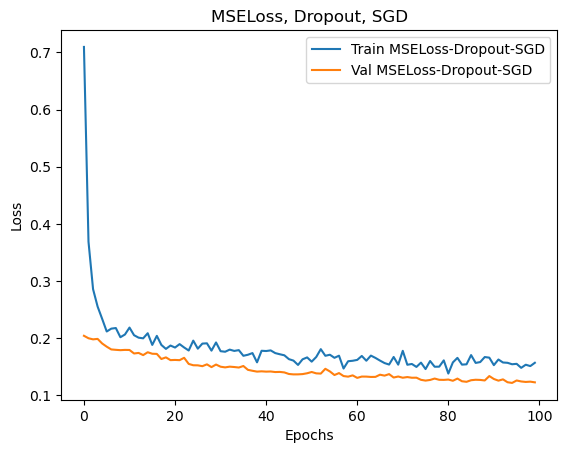

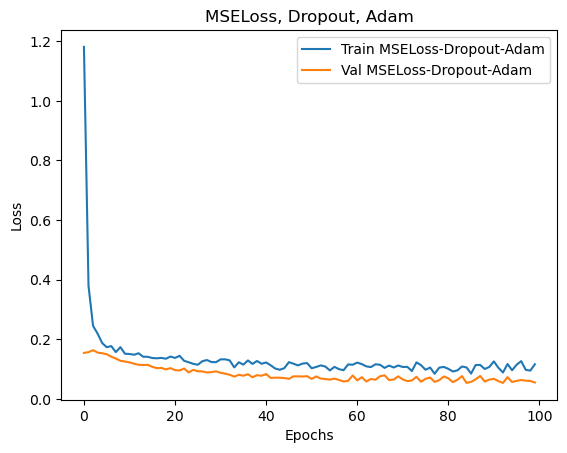

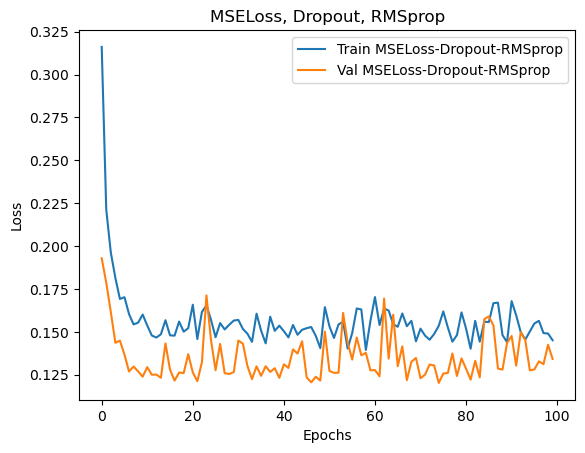

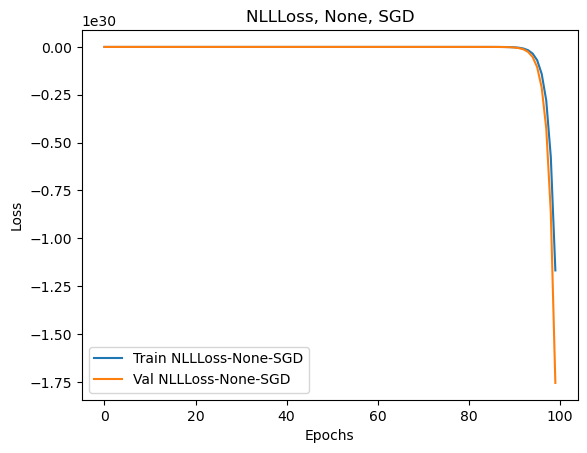

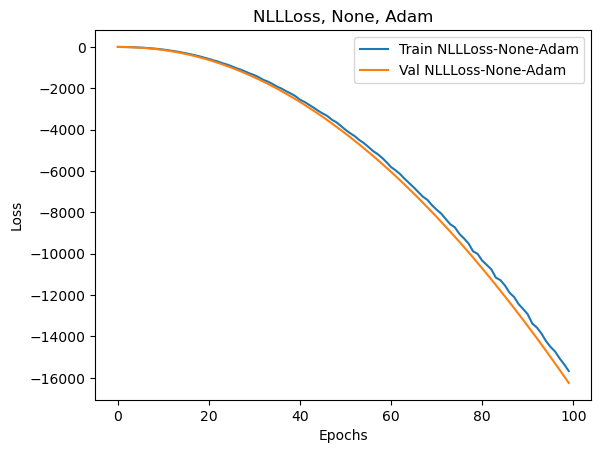

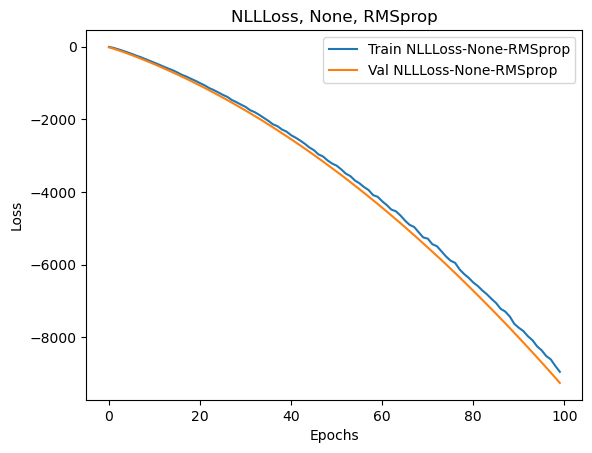

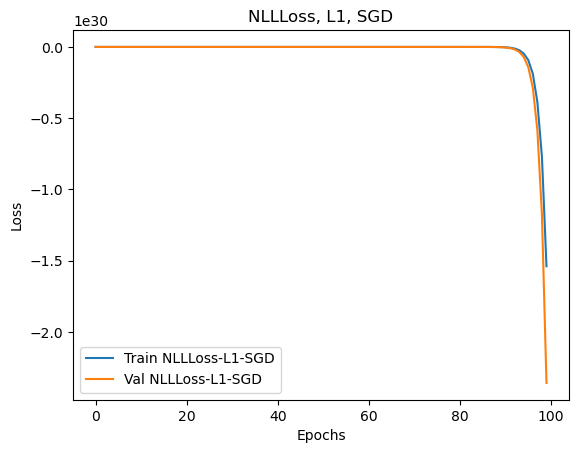

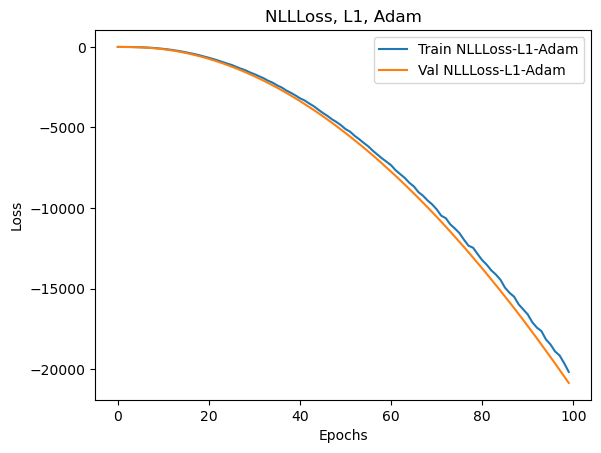

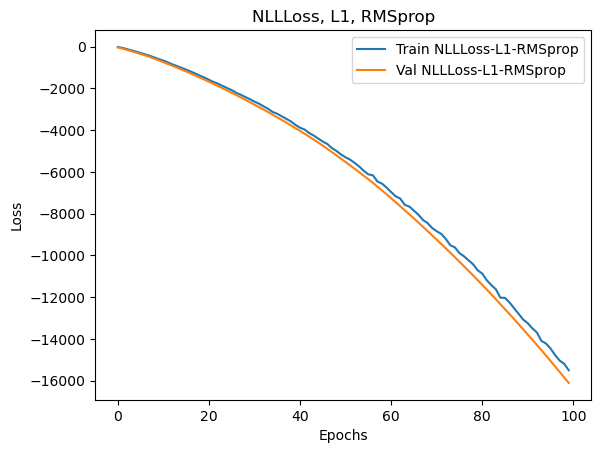

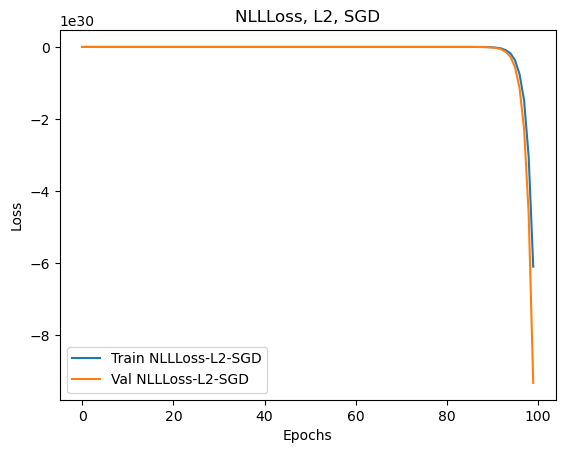

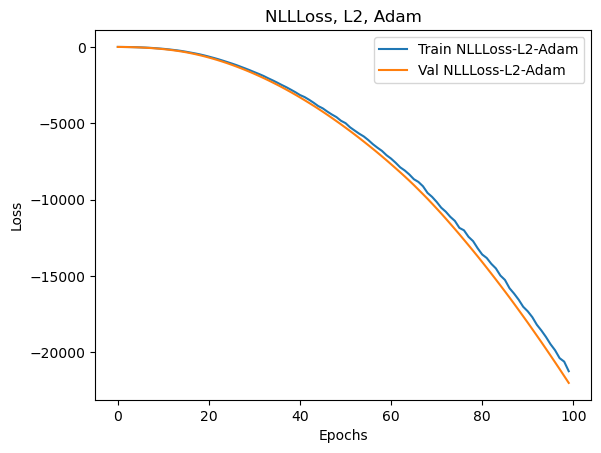

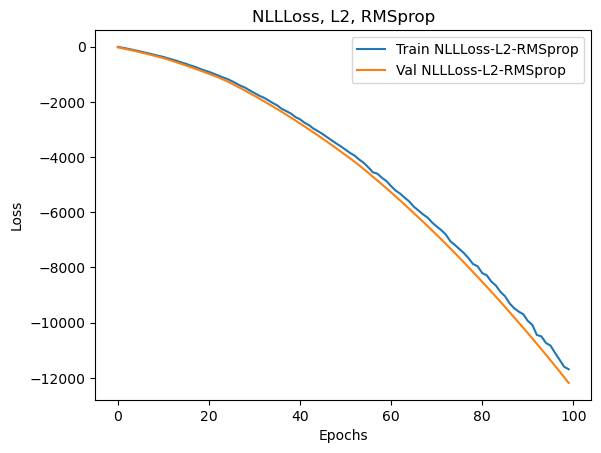

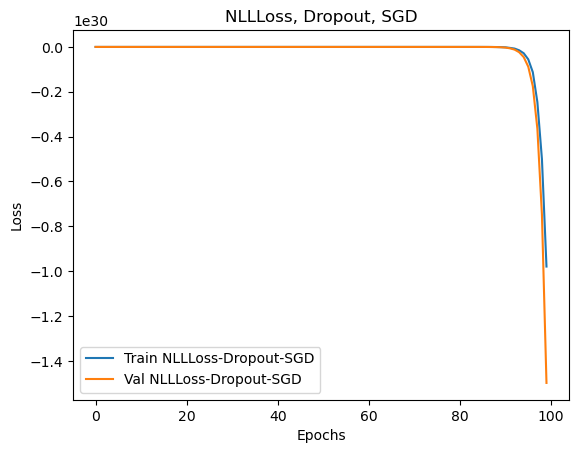

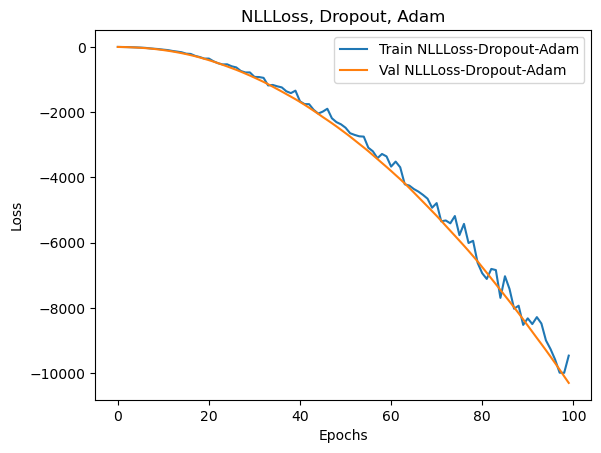

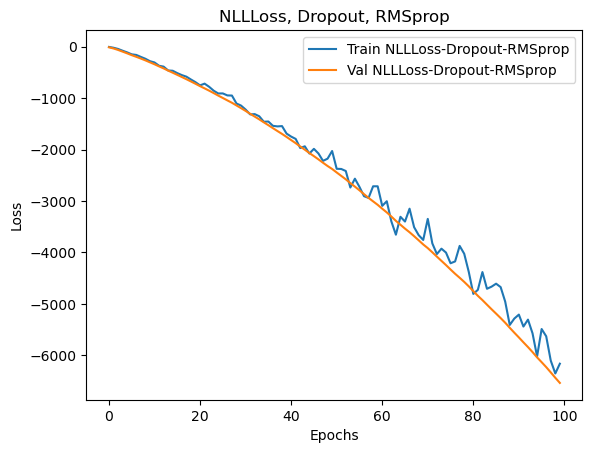

In [29]:
num_classes = 3

for loss_name, loss_fn in loss_functions.items():
    for reg_name, (l1_lambda, l2_lambda, dropout_prob) in regularizations.items():
        for opt_name, opt_fn in optimizers.items():
            model = FeedforwardNNWithDropout(input_size, hidden_size, output_size, dropout_prob)
            optimizer = opt_fn(model.parameters(), lr=0.01)
            
            train_losses = []
            val_losses = []
            start_time = time.time()

            for epoch in range(num_epochs):
                model.train()
                total_train_loss = 0
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    
                    # Aplicar one-hot encoding si se usa MSELoss
                    if loss_name == 'MSELoss':
                        y_batch_one_hot = to_one_hot(y_batch, num_classes)
                        loss = loss_fn(outputs, y_batch_one_hot)
                    else:
                        loss = loss_fn(outputs, y_batch)
                    
                    reg_loss = apply_l1_l2_regularization(model, l1_lambda, l2_lambda)
                    total_loss = loss + reg_loss
                    total_loss.backward()
                    optimizer.step()
                    total_train_loss += total_loss.item()

                train_losses.append(total_train_loss / len(train_loader))

                # Validación
                model.eval()
                total_val_loss = 0
                correct = 0
                with torch.no_grad():
                    for X_batch, y_batch in val_loader:
                        outputs = model(X_batch)
                        if loss_name == 'MSELoss':
                            y_batch_one_hot = to_one_hot(y_batch, num_classes)
                            loss = loss_fn(outputs, y_batch_one_hot)
                        else:
                            loss = loss_fn(outputs, y_batch)
                        
                        total_val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        correct += (predicted == y_batch).sum().item()

                val_losses.append(total_val_loss / len(val_loader))
                accuracy = correct / len(val_dataset)

            elapsed_time = time.time() - start_time
            results.append({
                'Loss Function': loss_name,
                'Regularization': reg_name,
                'Optimizer': opt_name,
                'Train Loss': train_losses,
                'Validation Loss': val_losses,
                'Final Accuracy': accuracy,
                'Time (s)': elapsed_time
            })

# Visualizar los resultados
df_results = pd.DataFrame(results)
print(df_results[['Loss Function', 'Regularization', 'Optimizer', 'Final Accuracy', 'Time (s)']])

# Graficar las pérdidas
for index, result in df_results.iterrows():
    plt.plot(result['Train Loss'], label=f"Train {result['Loss Function']}-{result['Regularization']}-{result['Optimizer']}")
    plt.plot(result['Validation Loss'], label=f"Val {result['Loss Function']}-{result['Regularization']}-{result['Optimizer']}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"{result['Loss Function']}, {result['Regularization']}, {result['Optimizer']}")
    plt.show()


In [38]:
df_results[['Loss Function', 'Regularization', 'Optimizer', 'Final Accuracy', 'Time (s)']]

Loss Function Regularization Optimizer  Final Accuracy  Time (s)
0    CrossEntropyLoss           None       SGD        0.866667  0.535511
1    CrossEntropyLoss           None      Adam        0.966667  0.768402
2    CrossEntropyLoss           None   RMSprop        0.966667  0.721725
3    CrossEntropyLoss             L1       SGD        0.900000  0.643309
4    CrossEntropyLoss             L1      Adam        0.966667  0.707974
..                ...            ...       ...             ...       ...
151           NLLLoss             L2      Adam        0.300000  1.142322
152           NLLLoss             L2   RMSprop        0.366667  1.042947
153           NLLLoss        Dropout       SGD        0.366667  0.928355
154           NLLLoss        Dropout      Adam        0.300000  1.198200
155           NLLLoss        Dropout   RMSprop        0.300000  1.158916

[156 rows x 5 columns]

In [39]:
df_results.to_csv('results.csv', index=False)

#### **Velocidad de Convergencia**
1. **Optimización:**
   - **Adam** y **RMSprop** mostraron una convergencia más rápida en comparación con **SGD**. Esto es evidente en los tiempos de ejecución más bajos y en cómo las pérdidas de entrenamiento y validación disminuyen rápidamente en las primeras épocas.
   - **SGD** presentó una convergencia más lenta, pero eventualmente alcanzó resultados competitivos en algunas configuraciones. Sin embargo, es más sensible a la configuración de hiperparámetros como la tasa de aprendizaje, lo que podría explicar su rendimiento más bajo en algunos casos.

2. **Regularización:**
   - El uso de **Dropout** aumentó el tiempo de convergencia debido a su naturaleza estocástica, lo que introduce ruido en el proceso de entrenamiento. Sin embargo, esta técnica es efectiva para prevenir el sobreajuste, lo que es evidente en las combinaciones que utilizan **Dropout** con optimizadores avanzados como **Adam** y **RMSprop**.
   - **L1** y **L2** también ralentizan la convergencia al añadir penalizaciones, pero estas técnicas contribuyen a mejorar la generalización al evitar pesos excesivamente grandes en la red.

3. **Función de Pérdida:**
   - **CrossEntropyLoss** mostró una convergencia más rápida y estable en comparación con **MSELoss** en tareas de clasificación, lo que es esperable dado que está específicamente diseñada para este tipo de problemas. **MSELoss** puede llevar a una convergencia más lenta y a veces inestable debido a las diferencias de escala en los gradientes.

#### **Rendimiento Final**
1. **Optimización:**
   - **Adam** y **RMSprop** consistentemente lograron la **mayor precisión final** en varias combinaciones, superando a **SGD**. Esto refuerza la idea de que los optimizadores adaptativos, que ajustan las tasas de aprendizaje para cada parámetro, son más efectivos para encontrar mínimos globales en espacios de alta dimensión.

2. **Regularización:**
   - La **regularización L1** tendió a mejorar la precisión final en algunos casos al inducir sparsity (esparsidad) en los pesos, lo que puede ser beneficioso para modelos con muchas características irrelevantes.
   - **Dropout** también mostró mejoras en la precisión final, especialmente en combinaciones con **Adam**, debido a su capacidad para reducir el sobreajuste.

3. **Función de Pérdida:**
   - **CrossEntropyLoss** generalmente logró una **mejor precisión final** en comparación con **MSELoss**, confirmando que es más adecuada para problemas de clasificación multiclase. **MSELoss** puede inducir un error más grande debido a la diferencia en las magnitudes de los gradientes, lo que afecta negativamente la precisión.

#### **Conclusiones**
- **Adam** con **CrossEntropyLoss** y **Dropout** o **L2 regularization** parece ser la mejor combinación en términos de rendimiento final y velocidad de convergencia. Esto sugiere que los optimizadores adaptativos, combinados con técnicas de regularización adecuadas, ofrecen un equilibrio sólido entre velocidad de aprendizaje y generalización.
- **SGD**, aunque más lento, puede ser efectivo con una adecuada configuración de hiperparámetros y en situaciones donde el cálculo de gradientes exactos es crítico.
- **CrossEntropyLoss** es claramente superior para tareas de clasificación, mientras que **MSELoss** podría ser reservada para tareas de regresión u otras aplicaciones específicas donde se desee minimizar el error cuadrático medio.


# Ejercicio 2 - Repaso Teoría